In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm import tqdm
import time
import glob
from torch import nn
import torch.nn.functional as F

from dataset import KaggleDataset
from architecture import UNetWithResnet50Encoder
from train import train
from loss import FocalTverskyLoss


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


/home/trainouille_cs/Documents/kaggle/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/trainouille_cs/Documents/kaggle/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/trainouille_cs/Documents/kaggle/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 5
IMAGE_PATH = './msc-ai-2022/train_images/train_images/'
MASK_PATH = './msc-ai-2022/train_masks/train_masks/'

class config:
    BASE_PATH = "./msc-ai-2022/"
    TRAIN_IMG_PATH = BASE_PATH + "train_images/train_images"
    TRAIN_MASK_PATH = BASE_PATH + "train_masks/train_masks"
    TEST_IMG_PATH = BASE_PATH + "test_images/test_images"
    SAVE_PATH = "./models/trained.pt"


In [3]:
# Very simple train/test split
train_ratio = 0.8
train_set_last_idx = int(
    len(glob.glob(config.TRAIN_IMG_PATH + "/*")) * train_ratio)

train_img_paths = sorted(
    glob.glob(config.TRAIN_IMG_PATH + "/*"))[:train_set_last_idx]
train_mask_paths = sorted(
    glob.glob(config.TRAIN_MASK_PATH + "/*"))[:train_set_last_idx]
val_img_paths = sorted(
    glob.glob(config.TRAIN_IMG_PATH + "/*"))[train_set_last_idx:]
val_mask_paths = sorted(
    glob.glob(config.TRAIN_MASK_PATH + "/*"))[train_set_last_idx:]

# Create datasets
train_dataset = KaggleDataset(
    train_img_paths, train_mask_paths, train=True)
val_dataset = KaggleDataset(val_img_paths, val_mask_paths, train=False)

# Create dataloaders
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

idx_class = {
    0: "Background",
    1: "Property Roof",
    2: "Secondary Structure",
    3: "Swimming Pool",
    4: "Vehicle",
    5: "Grass",
    6: "Trees / Shrubs",
    7: "Solar Panels",
    8: "Chimney",
    9: "Street Light",
    10: "Window",
    11: "Satellite Antenna",
    12: "Garbage Bins",
    13: "Trampoline",
    14: "Road/Highway",
    15: "Under Construction / In Progress Status",
    16: "Power Lines & Cables",
    17: "Water Tank / Oil Tank",
    18: "Parking Area - Commercial",
    19: "Sports Complex / Arena",
    20: "Industrial Site",
    21: "Dense Vegetation / Forest",
    22: "Water Body",
    23: "Flooded",
    24: "Boat",
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(
    'mps' if torch.backends.mps.is_available() else device)
print('Using device:', device)
epochs = 15
lr = 0.0009
model = UNetWithResnet50Encoder(n_classes=len(idx_class.keys())).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# criterion = nn.CrossEntropyLoss()
criterion = FocalTverskyLoss()

train(model, epochs, optimizer, criterion, train_dataloader, val_dataloader, device, idx_class)

torch.save(model.state_dict(), config.SAVE_PATH)


Using device: cuda


100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


TRAIN       Epoch: 0 | Epoch metrics | loss: 0.7687, accuracy: 3.585
VALIDATION  Epoch: 0 | Epoch metrics | loss: 0.6036, accuracy: 4.295
----------------------------------------------------------------------
one example:


ValueError: Number of columns must be a positive integer, not 0

<Figure size 400x0 with 0 Axes>

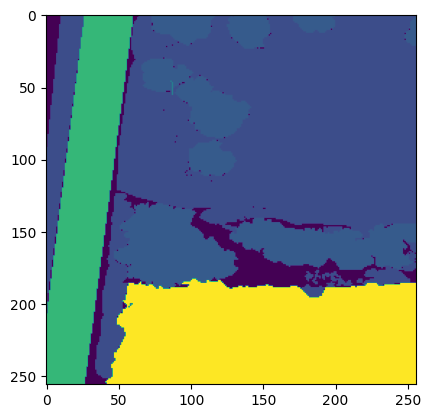

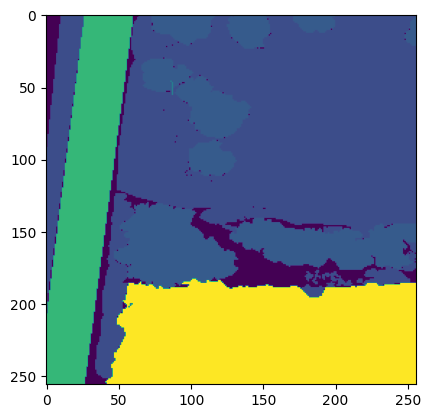

In [9]:
batch = next(train_dataloader._get_iterator())
x, y = batch

In [25]:
def plot_img_masks(img, masks):
    counter = 1
    plt.figure(figsize=(15, 15))
    plt.subplot(5, 6,counter)
    plt.axis("off")
    plt.title("image")
    plt.imshow(img.permute(1, 2, 0))
    counter += 1
    for i in range(masks.shape[0]):
        plt.subplot(5, 6, counter)
        plt.axis("off")
        plt.title(idx_class[i])
        plt.imshow(masks[i])
        counter += 1
    plt.show()

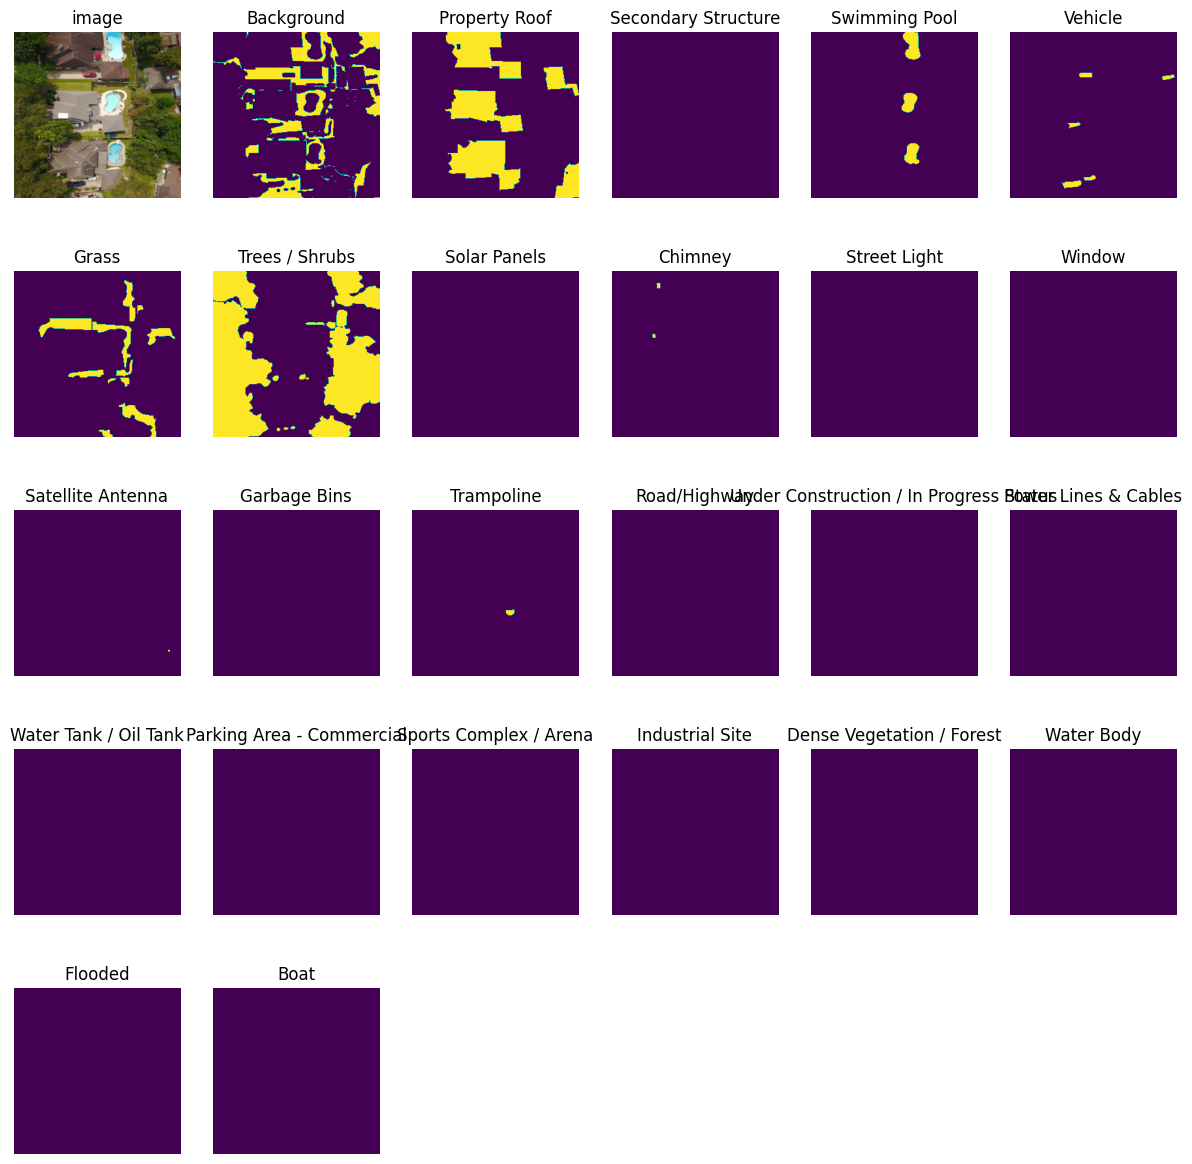

NameError: name 'model' is not defined

In [26]:
batch = train_dataset.__getitem__(1)
plot_img_masks(batch[0], batch[1])
preds =F.sigmoid(model(batch[0]))
plot_img_masks(batch[0], preds)

In [33]:
start = time.time()
for batch in tqdm(train_dataloader):
    img_batch, img_mask = batch

for batch in tqdm(val_dataloader):
    img_batch, img_mask = batch
      
end = time.time()
print(f'Seconds needed to load one train + val epoch: {end - start :.3f}')

100%|██████████| 7/7 [00:09<00:00,  1.40s/it]

Seconds needed to load one train + val epoch: 49.710


# Basic implementation

In [35]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, forward_expansion: int,  out_channels: int, expand: bool):
        super(BasicBlock, self).__init__()
        """
        A very simple convlution block. Reduces or expands the size of the image by a factor of 2.
        When using batchnorm, you can set bias=False to preceding convolution.
        """
        self.conv1 = nn.Conv2d(in_channels, forward_expansion, 3, stride=1, padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(forward_expansion)
        self.conv2 = nn.Conv2d(forward_expansion, out_channels, 3, stride=1, padding='same', bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if expand:
            self.scaling = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        else:
            self.scaling = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.scaling(x)
        return x

    
class SampleModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=25):
        super(SampleModel, self).__init__()
        
        # Create downsizing pass
        self.down = nn.ModuleList()
        self.down.append(BasicBlock(3, 256, 256, expand=False))
        self.down.append(BasicBlock(256, 512, 512, expand=False))
        self.down.append(BasicBlock(512, 512, 1024, expand=False))
        
        # Create bottleneck
        self.bottleneck = nn.Conv2d(1024, 1024, 3, stride=1, padding='same')
        
        # Create upsizing pass
        self.up = nn.ModuleList()
        self.up.append(BasicBlock(1024, 512, 512, expand=True))
        self.up.append(BasicBlock(512, 512, 256, expand=True))
        self.up.append(BasicBlock(256, 256, out_channels, expand=True))
        
    def forward(self, x):
        for block in self.down:
            x = block(x)
        x = self.bottleneck(x)
        for block in self.up:
            x = block(x)
        return x

# Res Net 50 implementation

In [27]:
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

# Loss function for segmentation task

In [51]:
#PyTorch
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device('mps' if torch.backends.mps.is_available() else device) 
print('Using device:', device)
epochs = 15
lr = 0.0003
model = UNetWithResnet50Encoder(n_classes=25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = FocalTverskyLoss().to(device)

Using device: mps


In [53]:
def train(model, epochs, optimizer, criterion):
    
    for epoch in range(epochs):
        
        train_losses = []
        train_accuracy = []
        val_losses = []
        val_accuracy = []
      
        ###### Train model ######
        model.train()
        for i, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            # Extract images and masks
            img_batch, mask_batch = batch  # img [B,3,H,W], mask[B,H,W]
            img_batch, mask_batch = img_batch.to(device), mask_batch.long().to(device)
            
            # Optimize network
            optimizer.zero_grad()
            output = model(img_batch) # output: [B, 25, H, W]
            loss = criterion(output, mask_batch)
            loss.backward()
            optimizer.step()
          
            # Save batch results
            train_losses.append(loss.item())
            output = F.sigmoid(output)
            preds = torch.where(output> 0.5, 1, 0)
            acc = torch.sum(preds == mask_batch).item() / (mask_batch.shape[0] * mask_batch.shape[1] * mask_batch.shape[2])
            # we divide by (batch_size * height * width) to get average accuracy per pixel
            train_accuracy.append(acc)

        ###### Validate model ######
        model.eval()      
        for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            #Extract data, labels
            img_batch, mask_batch = batch  # img [B,3,H,W], mask[B,H,W]
            img_batch, mask_batch = img_batch.to(device), mask_batch.long().to(device)

            #Validate model
            output = model(img_batch)
            loss = criterion(output, mask_batch)

            # Save batch results
            val_losses.append(loss.item())
            output = F.sigmoid(output)
            preds = torch.where(output> 0.5, 1, 0)
            acc = torch.sum(preds == mask_batch).item() / (mask_batch.shape[0] * mask_batch.shape[1] * mask_batch.shape[2])
            val_accuracy.append(acc)
      
        ##### Print epoch results ######
        print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, accuracy: {np.mean(train_accuracy):.3f}')        
        print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, accuracy: {np.mean(val_accuracy):.3f}')
        print('-' * 70)
        print('one example:')
        preds = F.sigmoid(model(batch[0].to(device)))[0]
        preds = torch.where(preds> 0.5, 1, 0)
        plot_img_masks(batch[0][0], batch[1][0])
        plot_img_masks(batch[0][0], preds.cpu().detach().numpy())
        print('-' * 70)

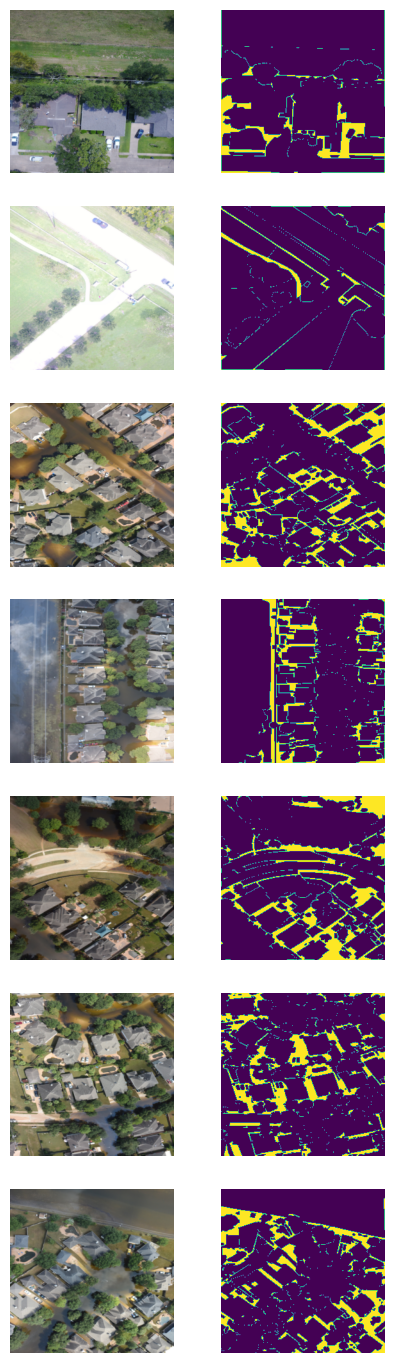

In [54]:
batch = next(train_dataloader._get_iterator())
plt.figure(figsize=(5, 20))
counter = 1
for i in range(1, batch[0].shape[0]):
    plt.subplot(8, 2, counter)
    counter += 1
    plt.axis("off")
    plt.imshow(batch[0][i].permute(1, 2, 0))
    plt.subplot(8, 2, counter)
    counter += 1
    plt.axis("off")
    plt.imshow(batch[1][i][0])
plt.show()

100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


TRAIN       Epoch: 0 | Epoch metrics | loss: 0.8985, accuracy: 155.221
VALIDATION  Epoch: 0 | Epoch metrics | loss: 0.8964, accuracy: 195.583
----------------------------------------------------------------------
one example:


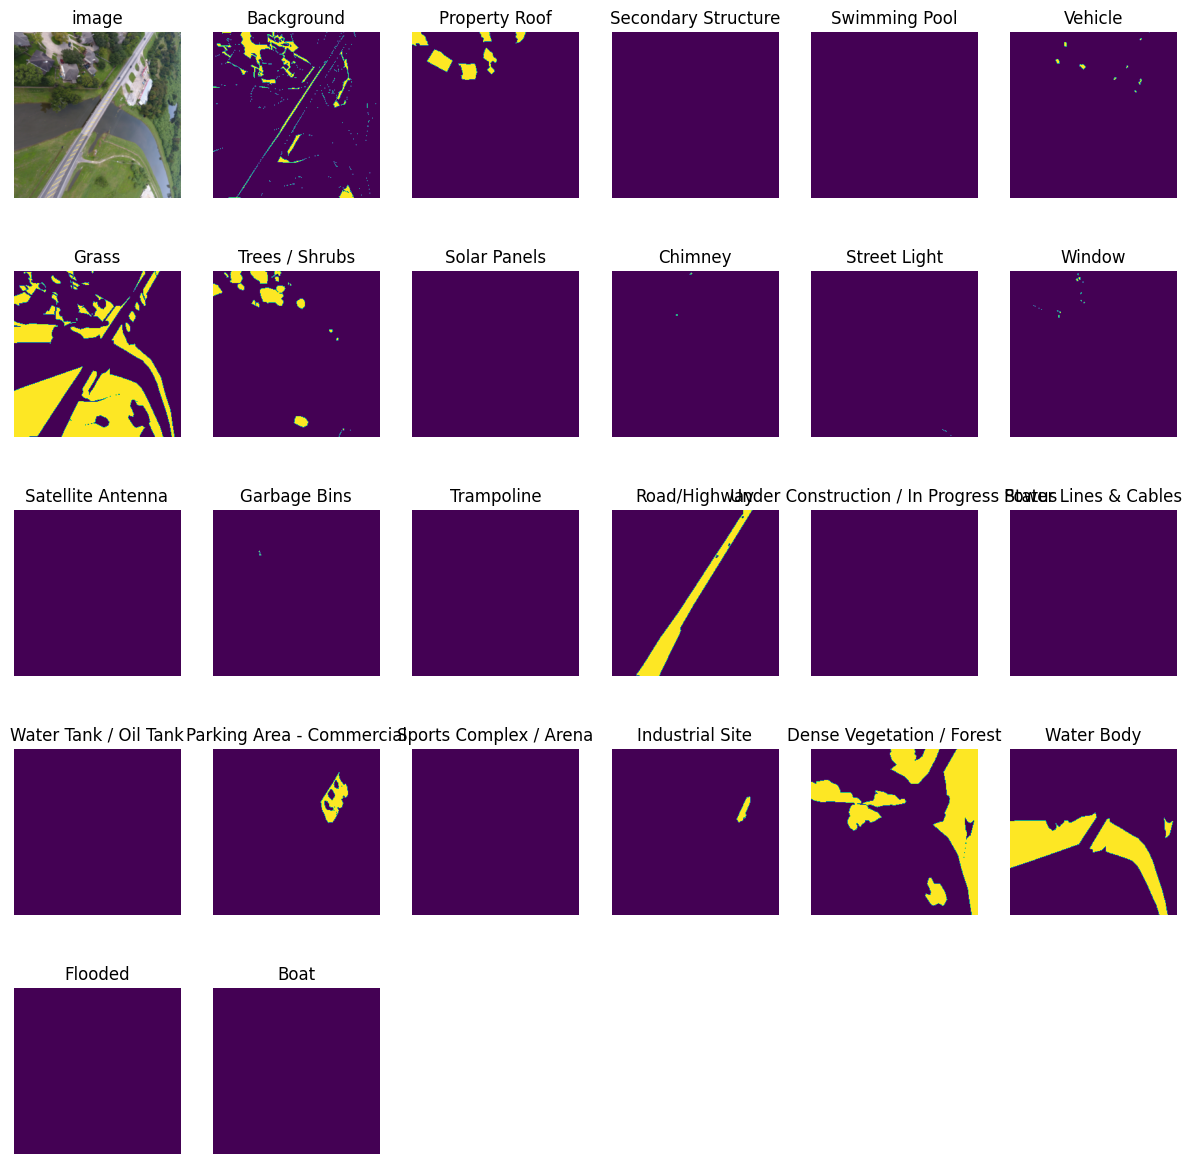

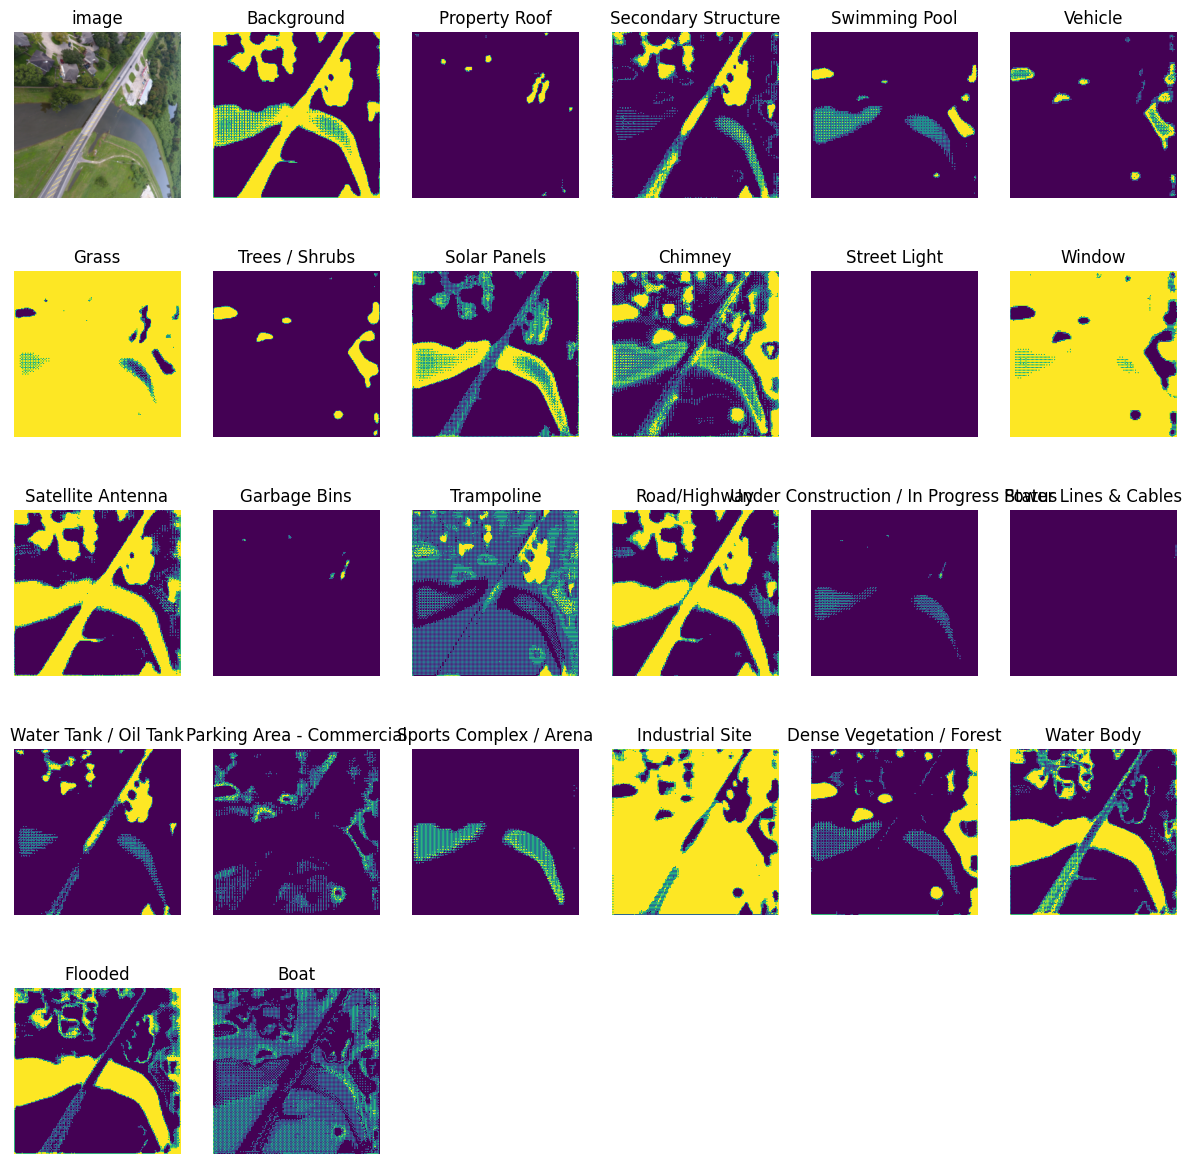

----------------------------------------------------------------------


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


TRAIN       Epoch: 1 | Epoch metrics | loss: 0.8705, accuracy: 197.080
VALIDATION  Epoch: 1 | Epoch metrics | loss: 0.8578, accuracy: 220.907
----------------------------------------------------------------------
one example:


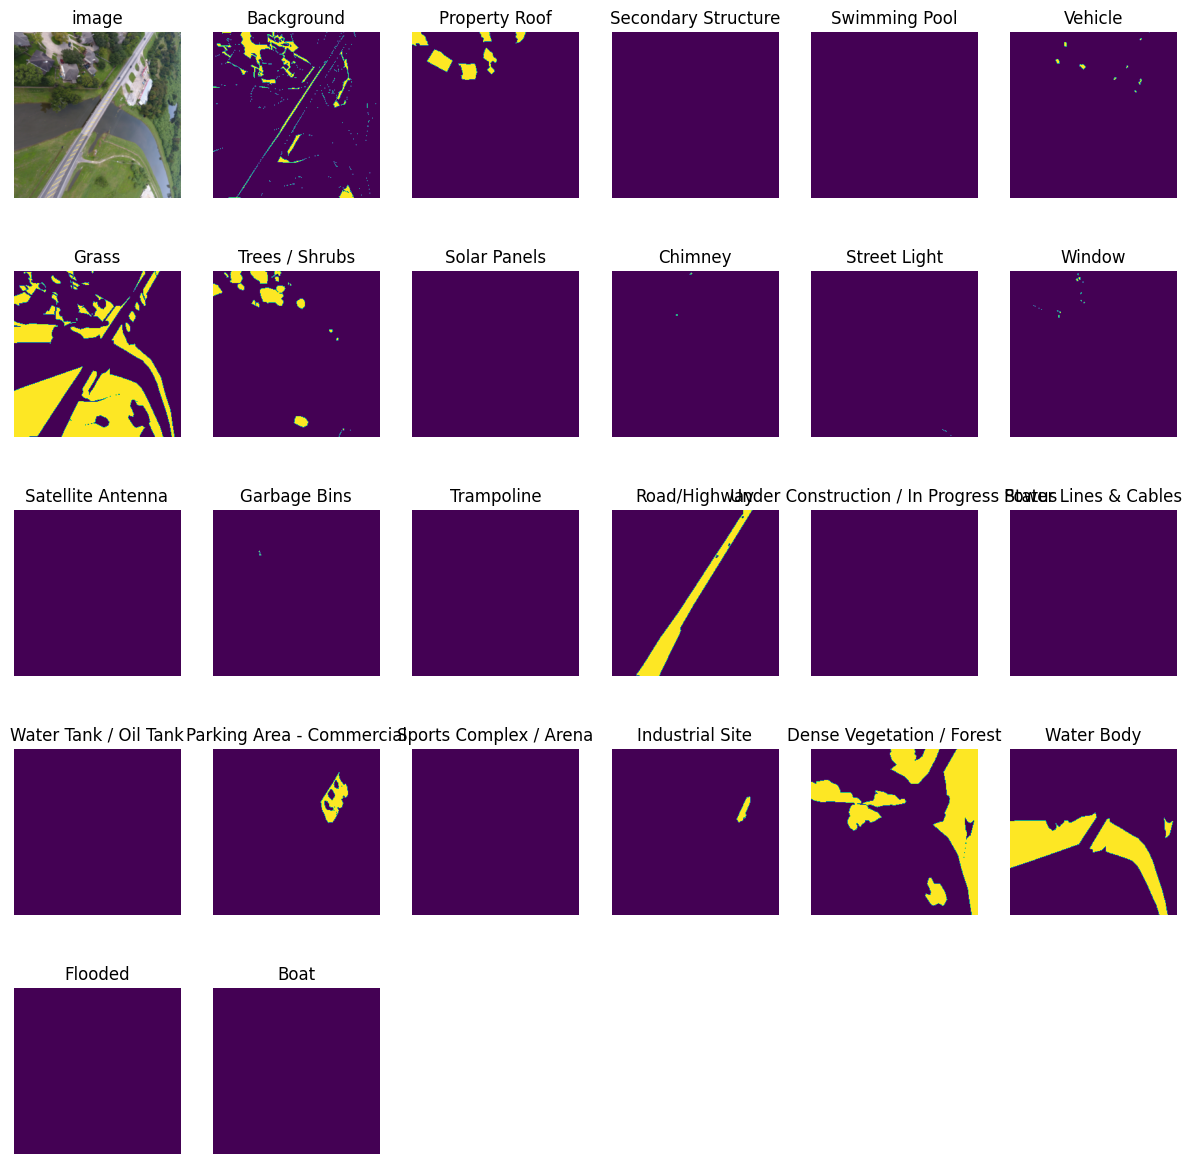

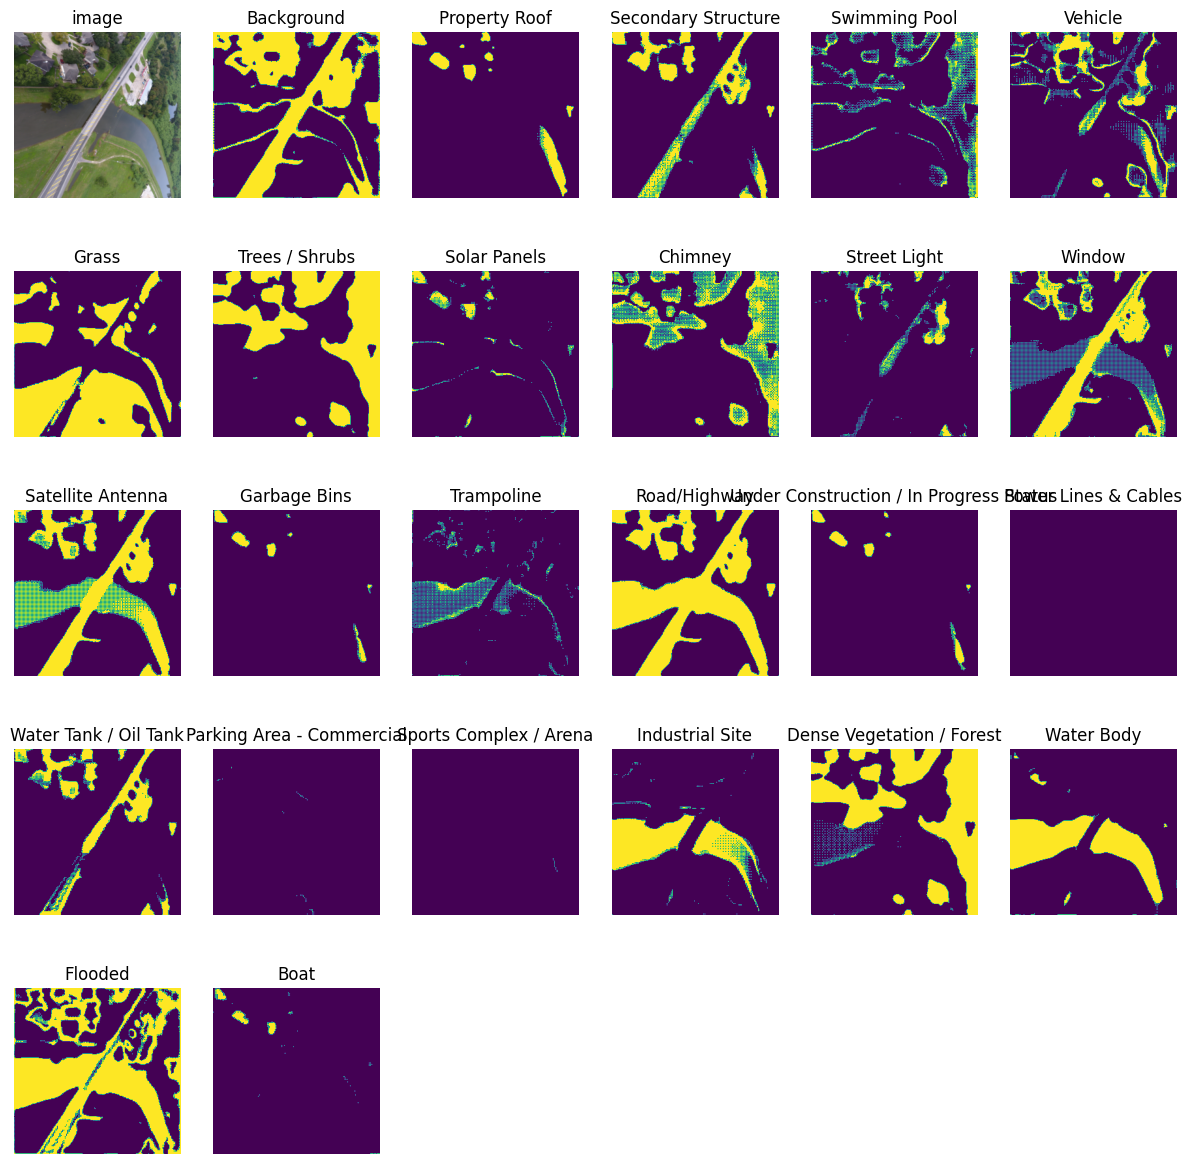

----------------------------------------------------------------------


100%|██████████| 7/7 [00:14<00:00,  2.11s/it]


TRAIN       Epoch: 2 | Epoch metrics | loss: 0.8494, accuracy: 226.188
VALIDATION  Epoch: 2 | Epoch metrics | loss: 0.8389, accuracy: 235.123
----------------------------------------------------------------------
one example:


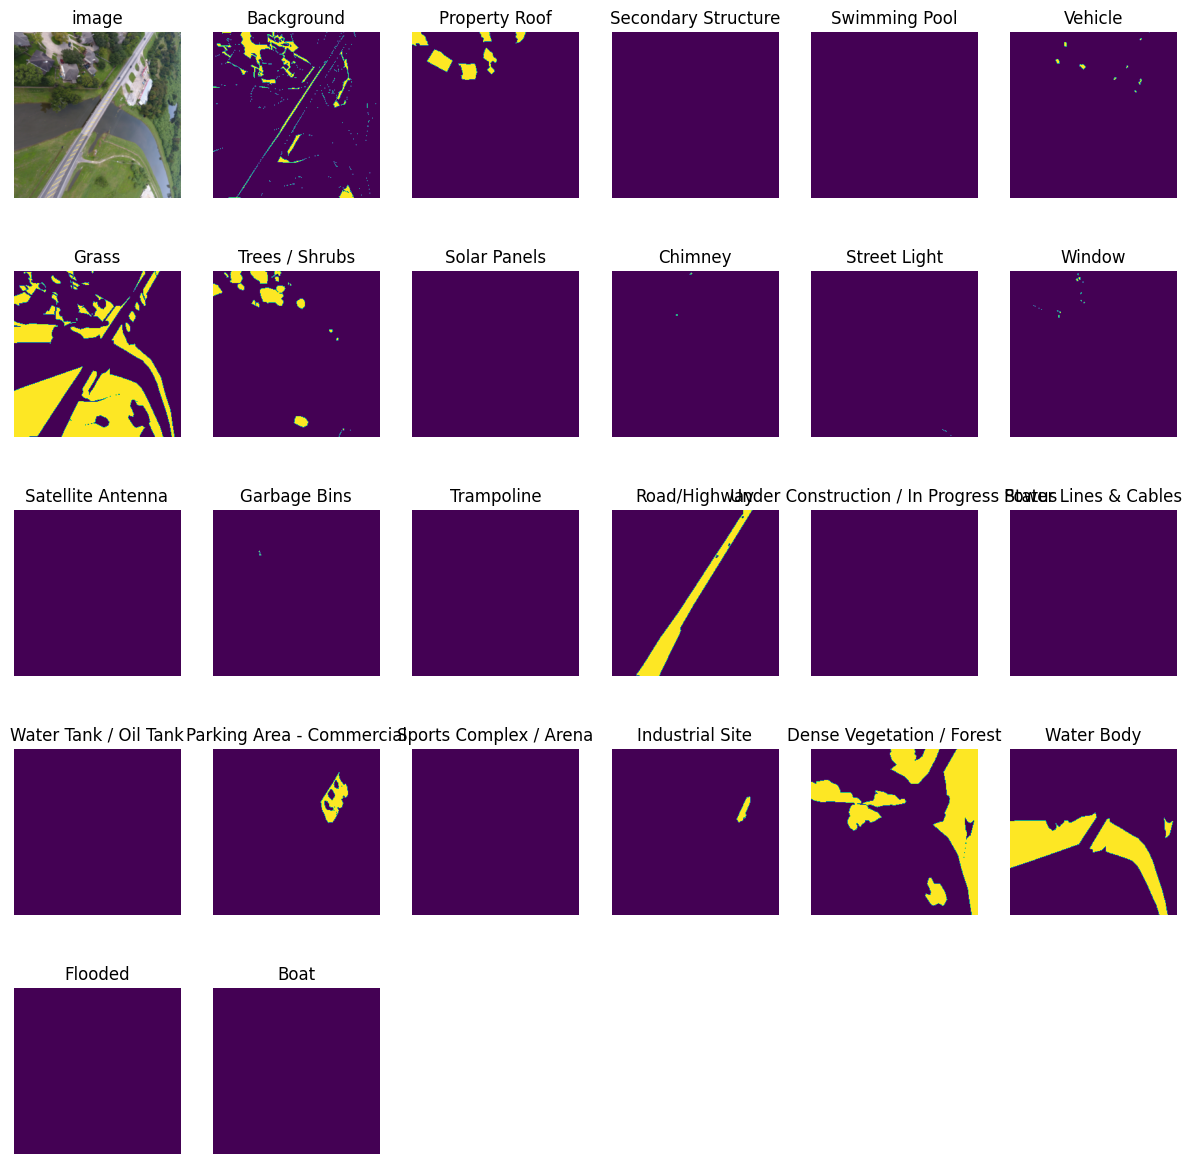

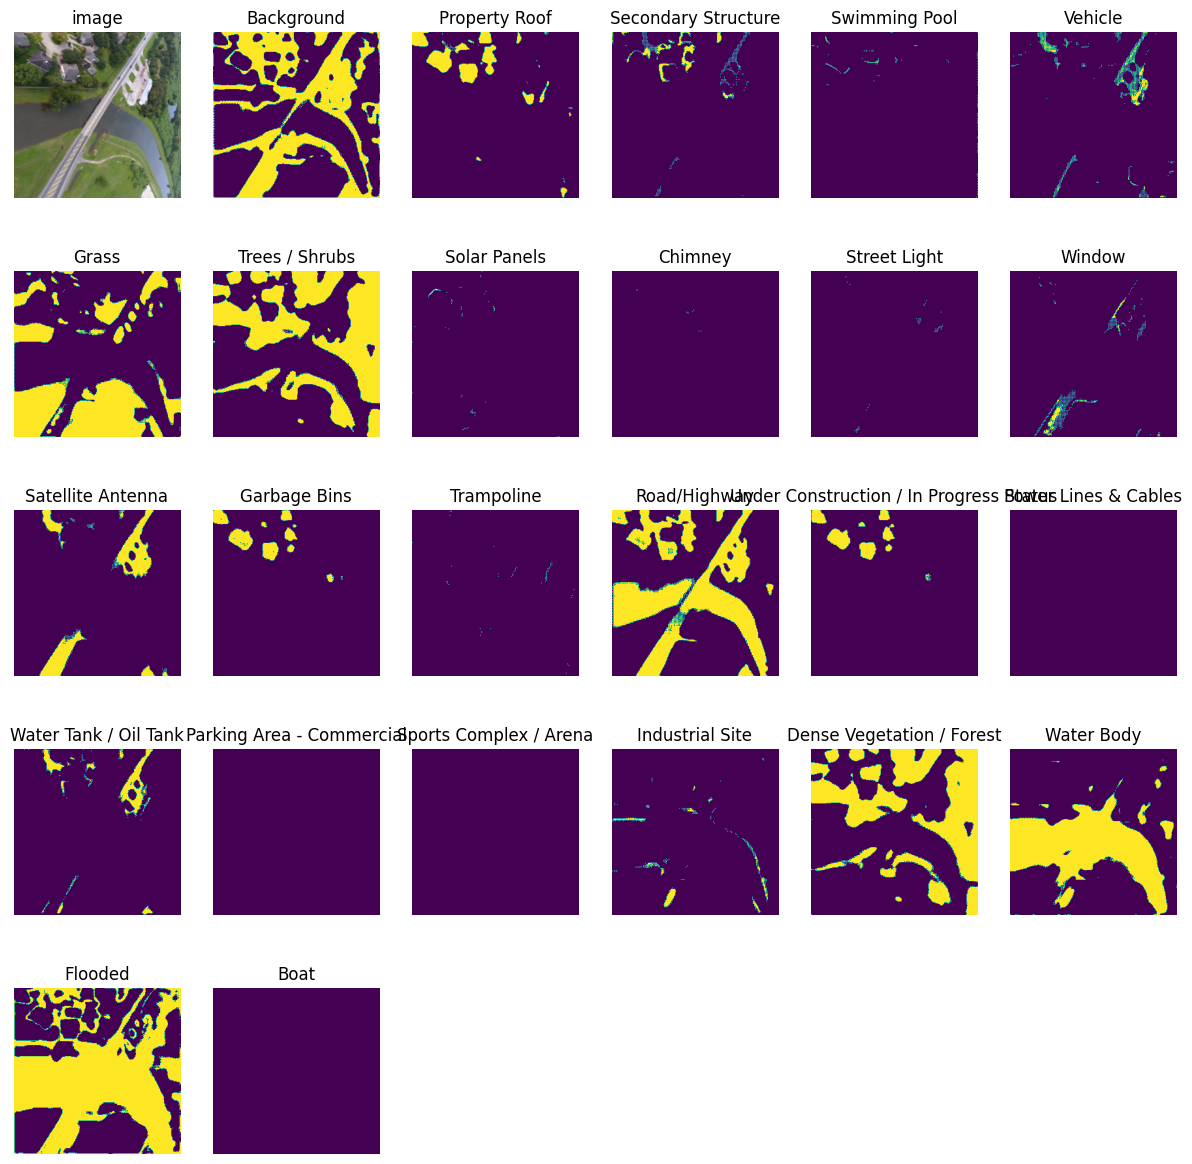

----------------------------------------------------------------------


100%|██████████| 7/7 [00:14<00:00,  2.13s/it]


TRAIN       Epoch: 3 | Epoch metrics | loss: 0.8252, accuracy: 237.662
VALIDATION  Epoch: 3 | Epoch metrics | loss: 0.8109, accuracy: 243.345
----------------------------------------------------------------------
one example:


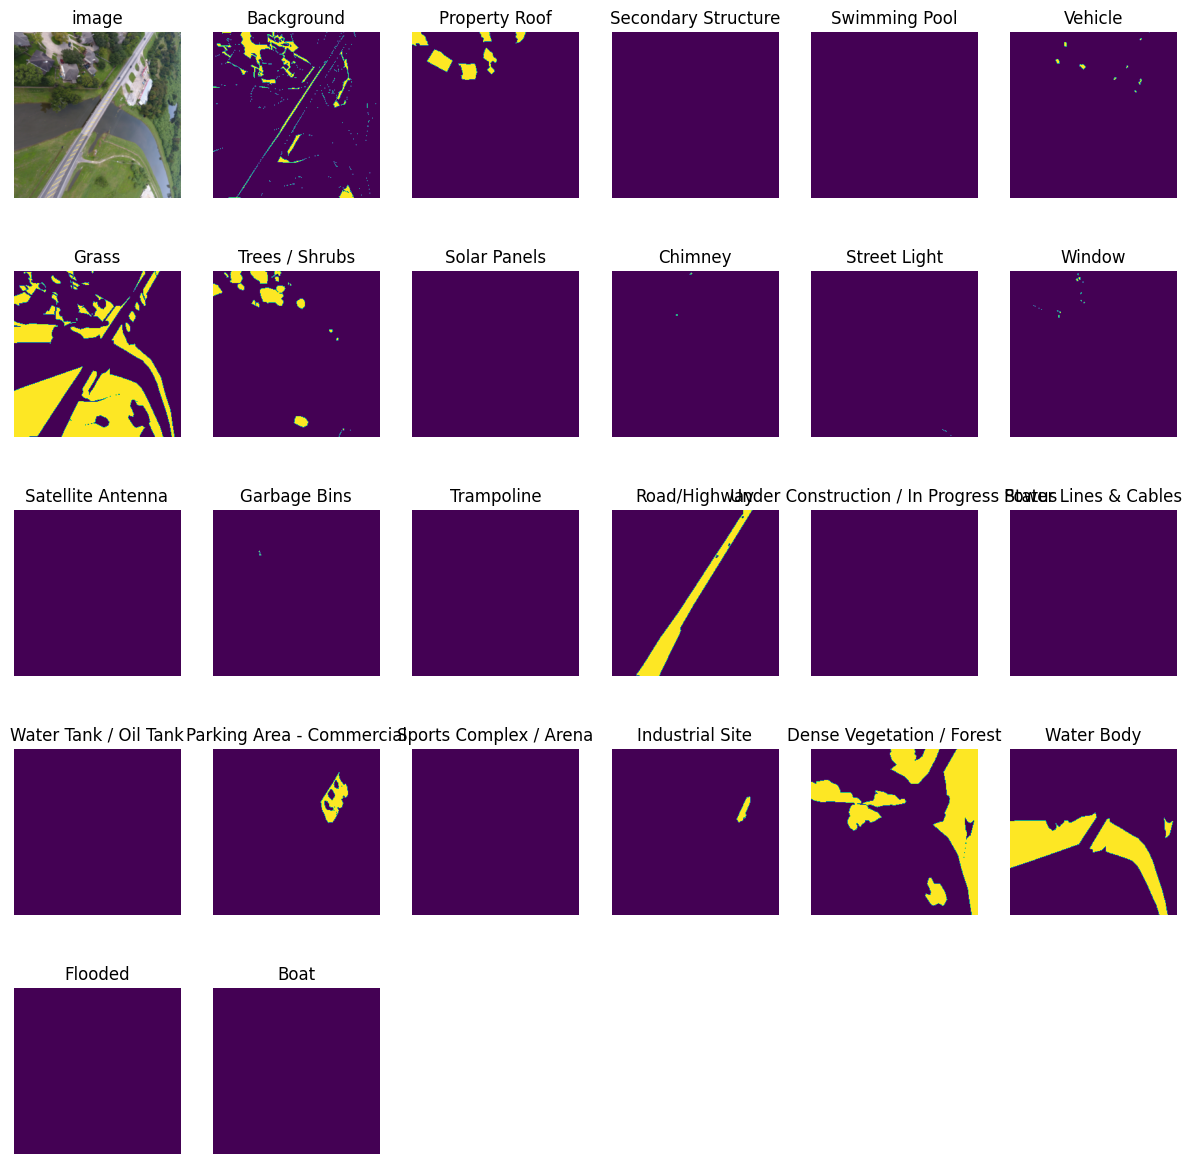

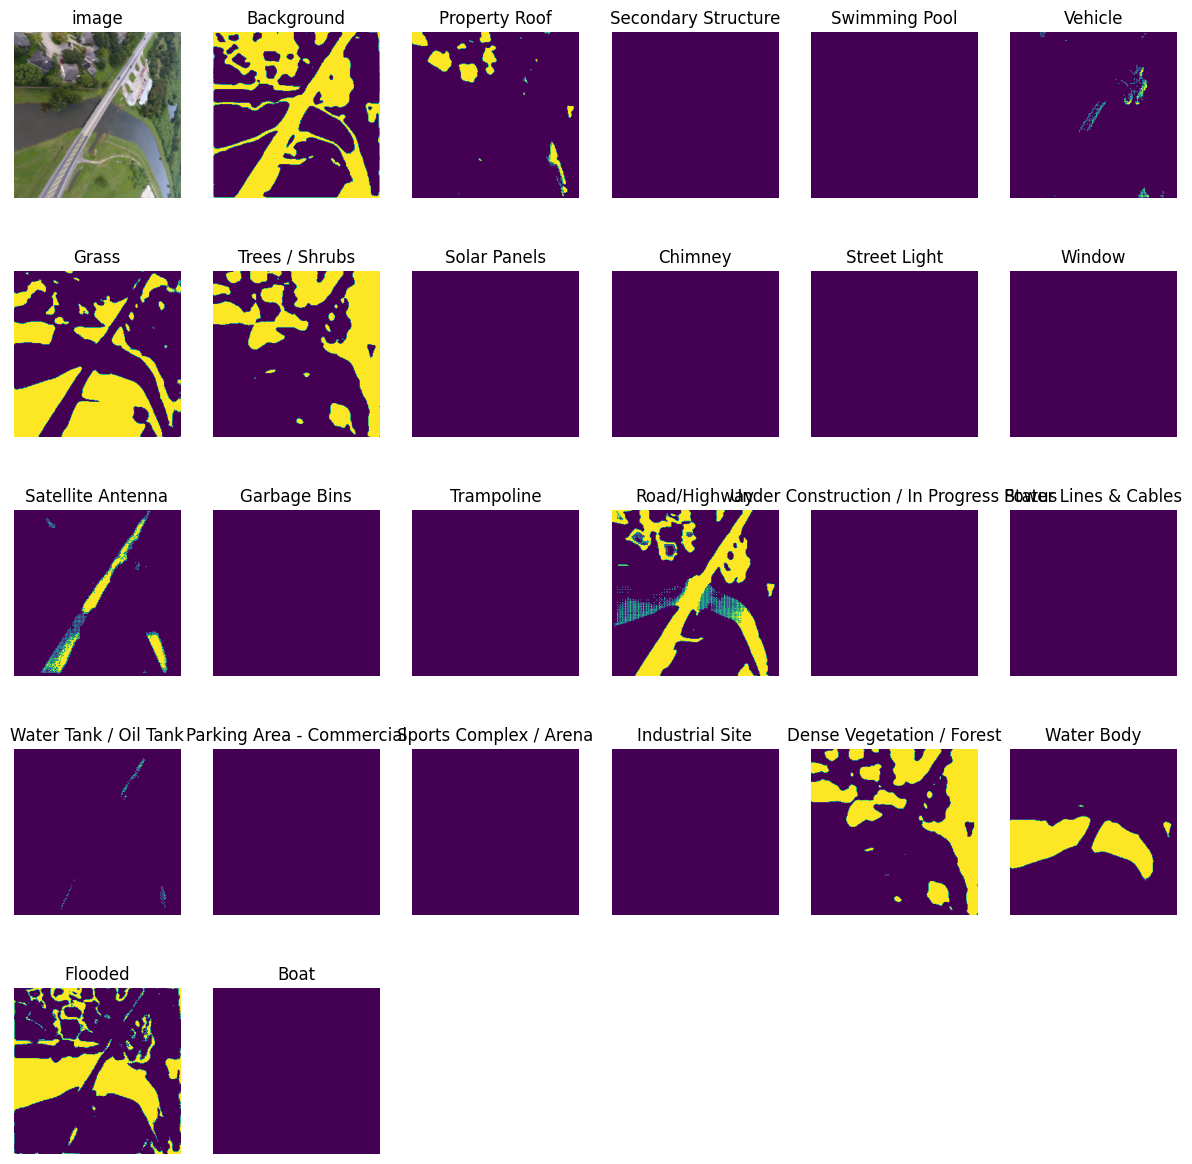

----------------------------------------------------------------------


100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


TRAIN       Epoch: 4 | Epoch metrics | loss: 0.7912, accuracy: 243.168
VALIDATION  Epoch: 4 | Epoch metrics | loss: 0.7834, accuracy: 243.656
----------------------------------------------------------------------
one example:


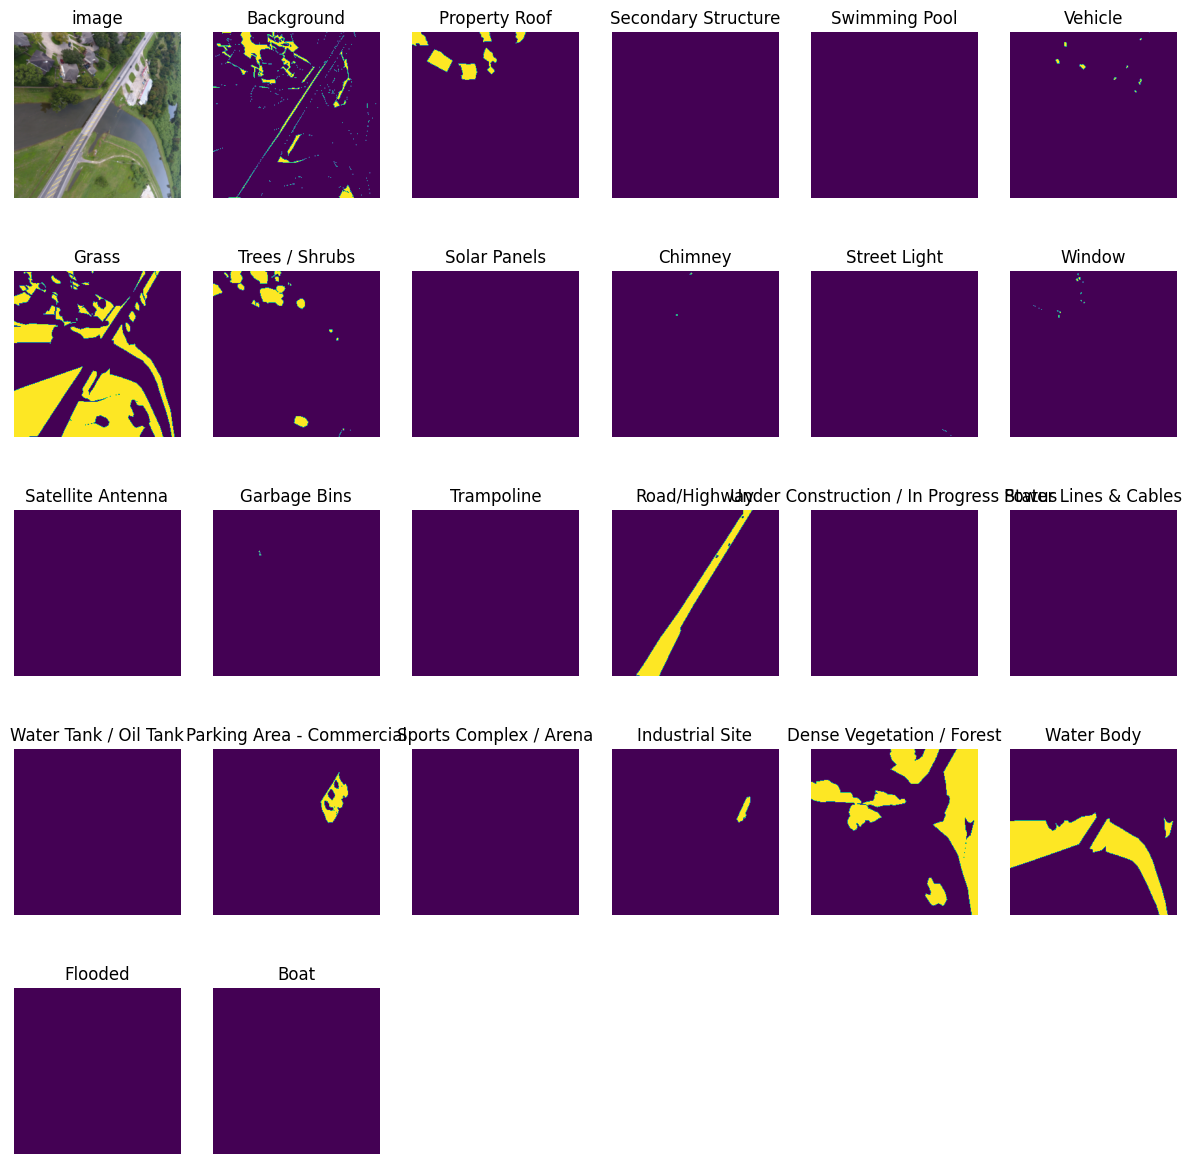

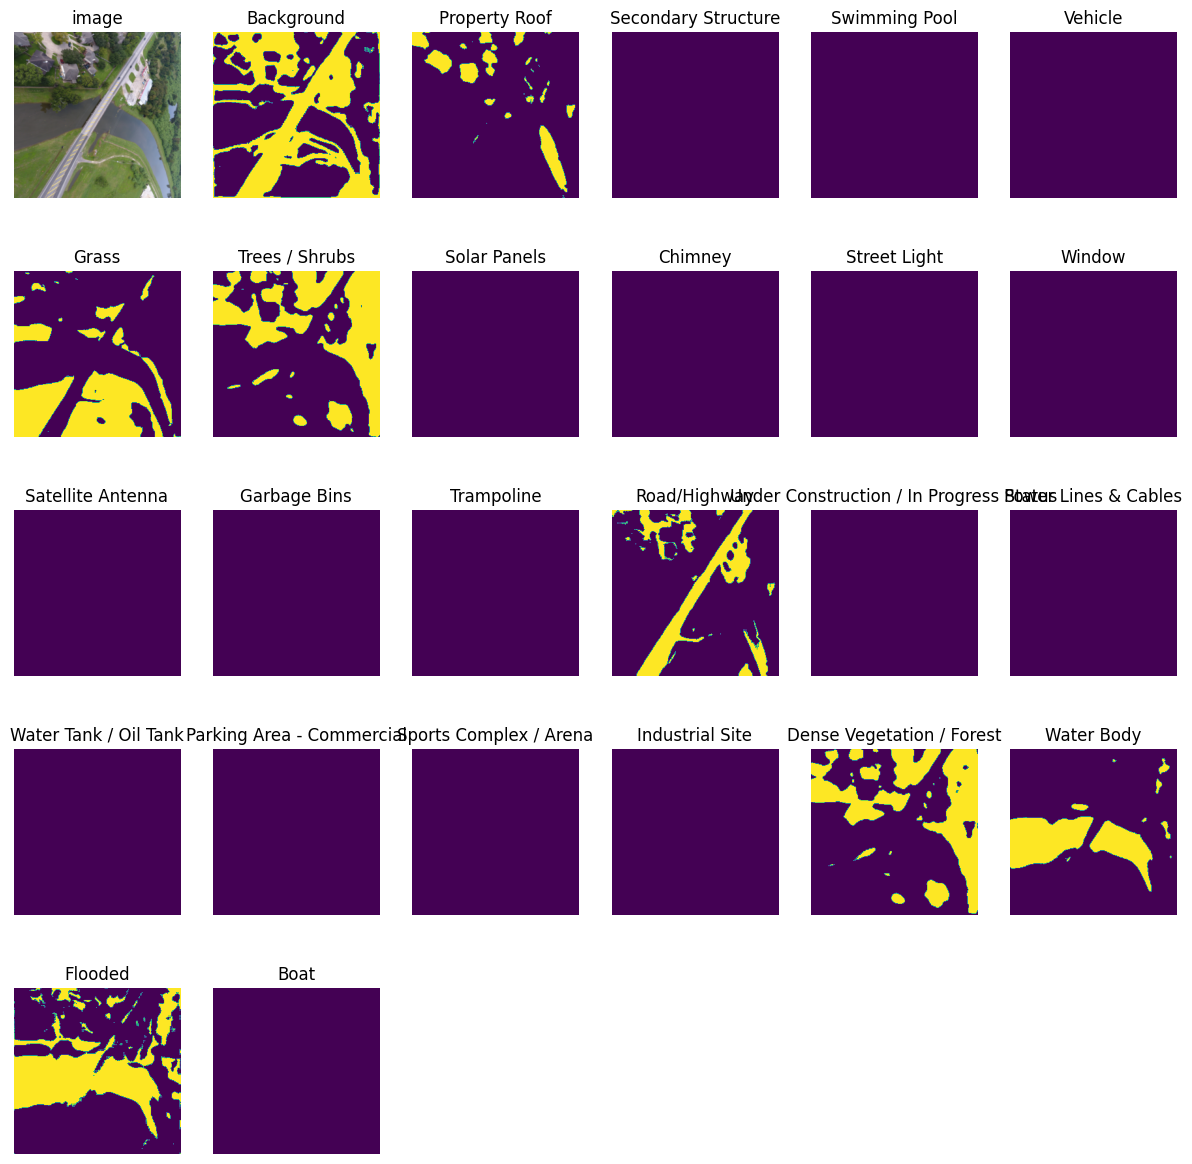

----------------------------------------------------------------------


100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


TRAIN       Epoch: 5 | Epoch metrics | loss: 0.7516, accuracy: 244.478
VALIDATION  Epoch: 5 | Epoch metrics | loss: 0.7596, accuracy: 244.938
----------------------------------------------------------------------
one example:


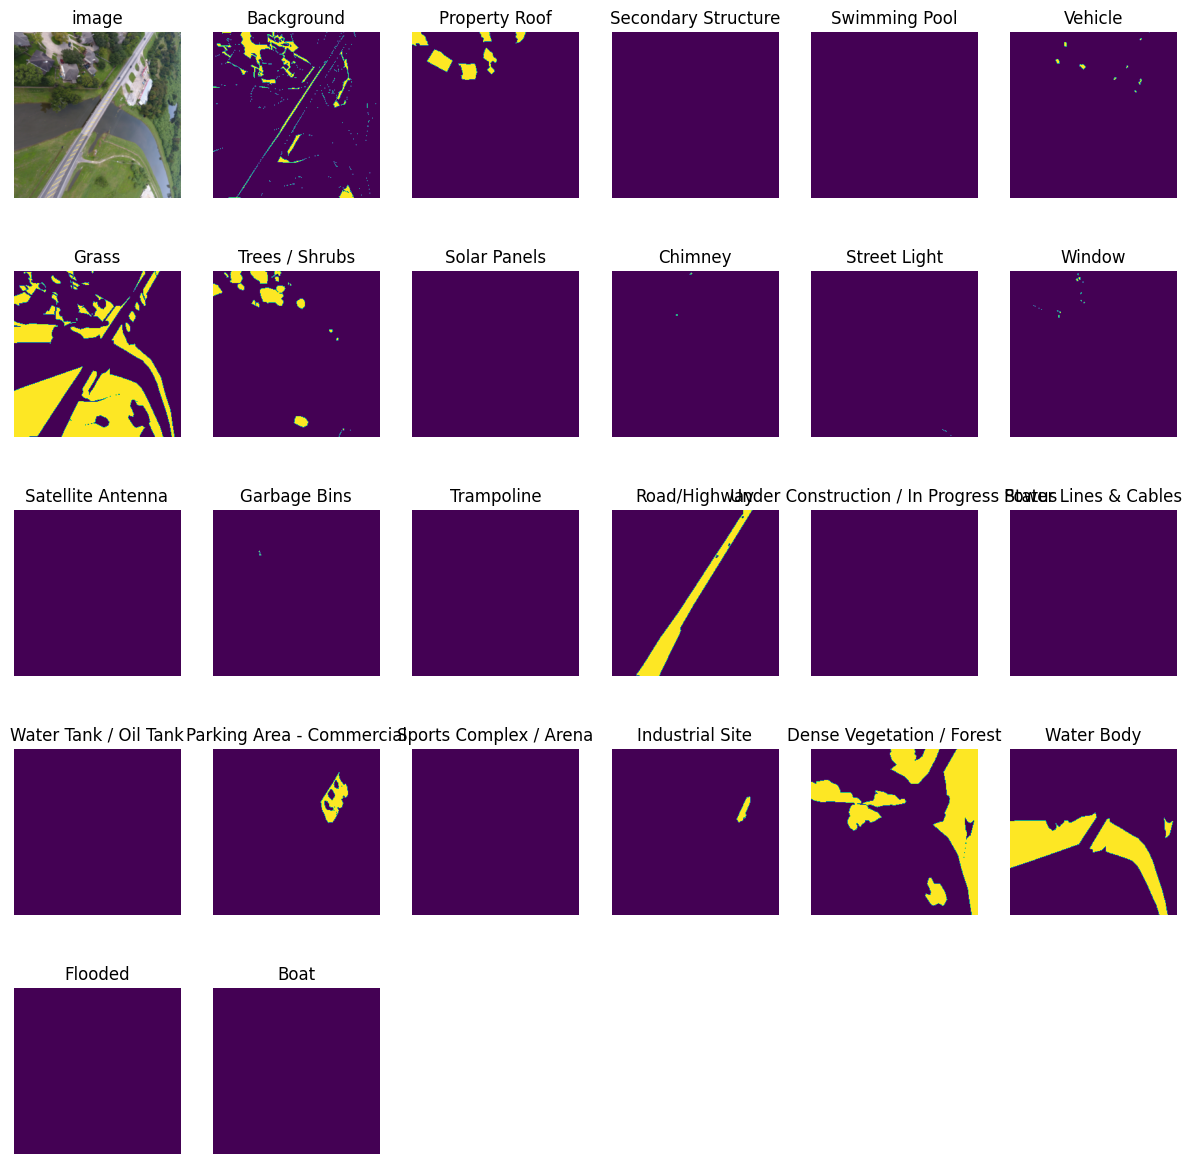

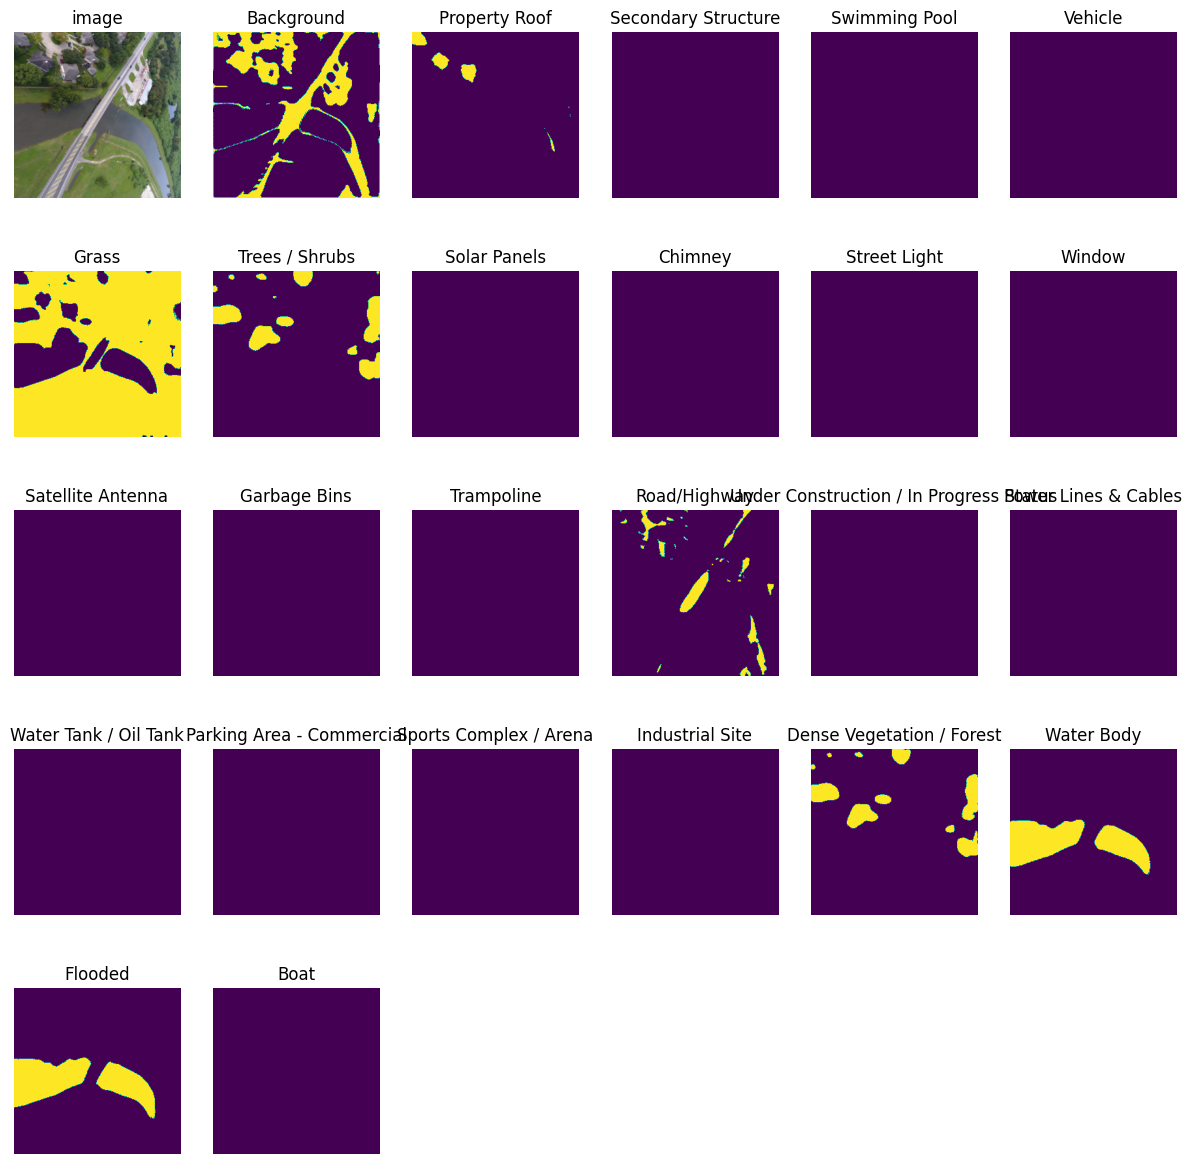

----------------------------------------------------------------------


100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


TRAIN       Epoch: 6 | Epoch metrics | loss: 0.7011, accuracy: 245.646
VALIDATION  Epoch: 6 | Epoch metrics | loss: 0.6971, accuracy: 245.273
----------------------------------------------------------------------
one example:


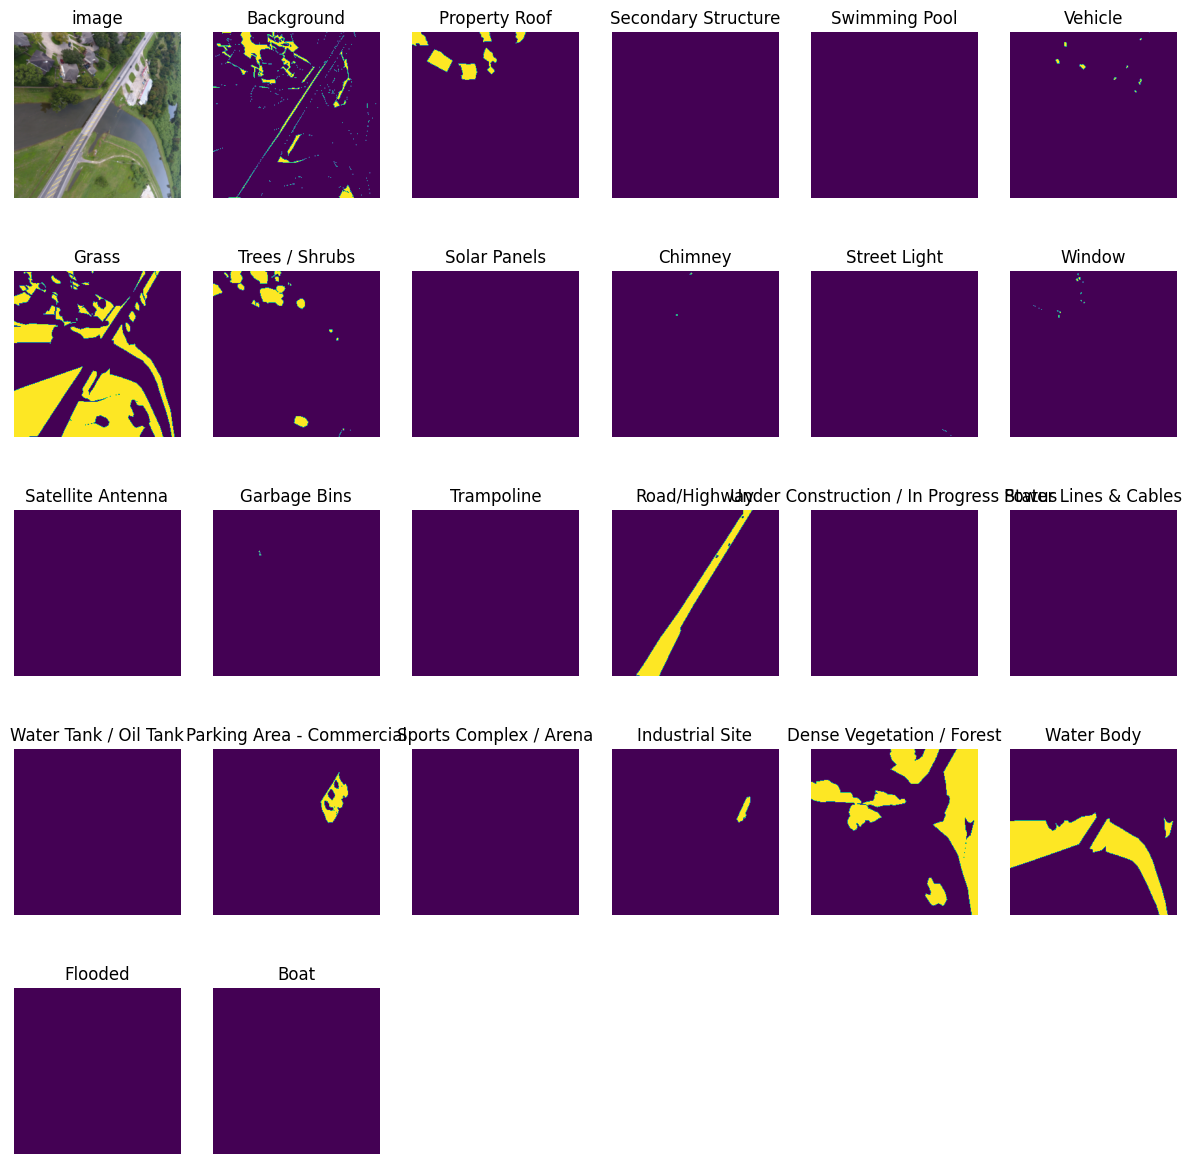

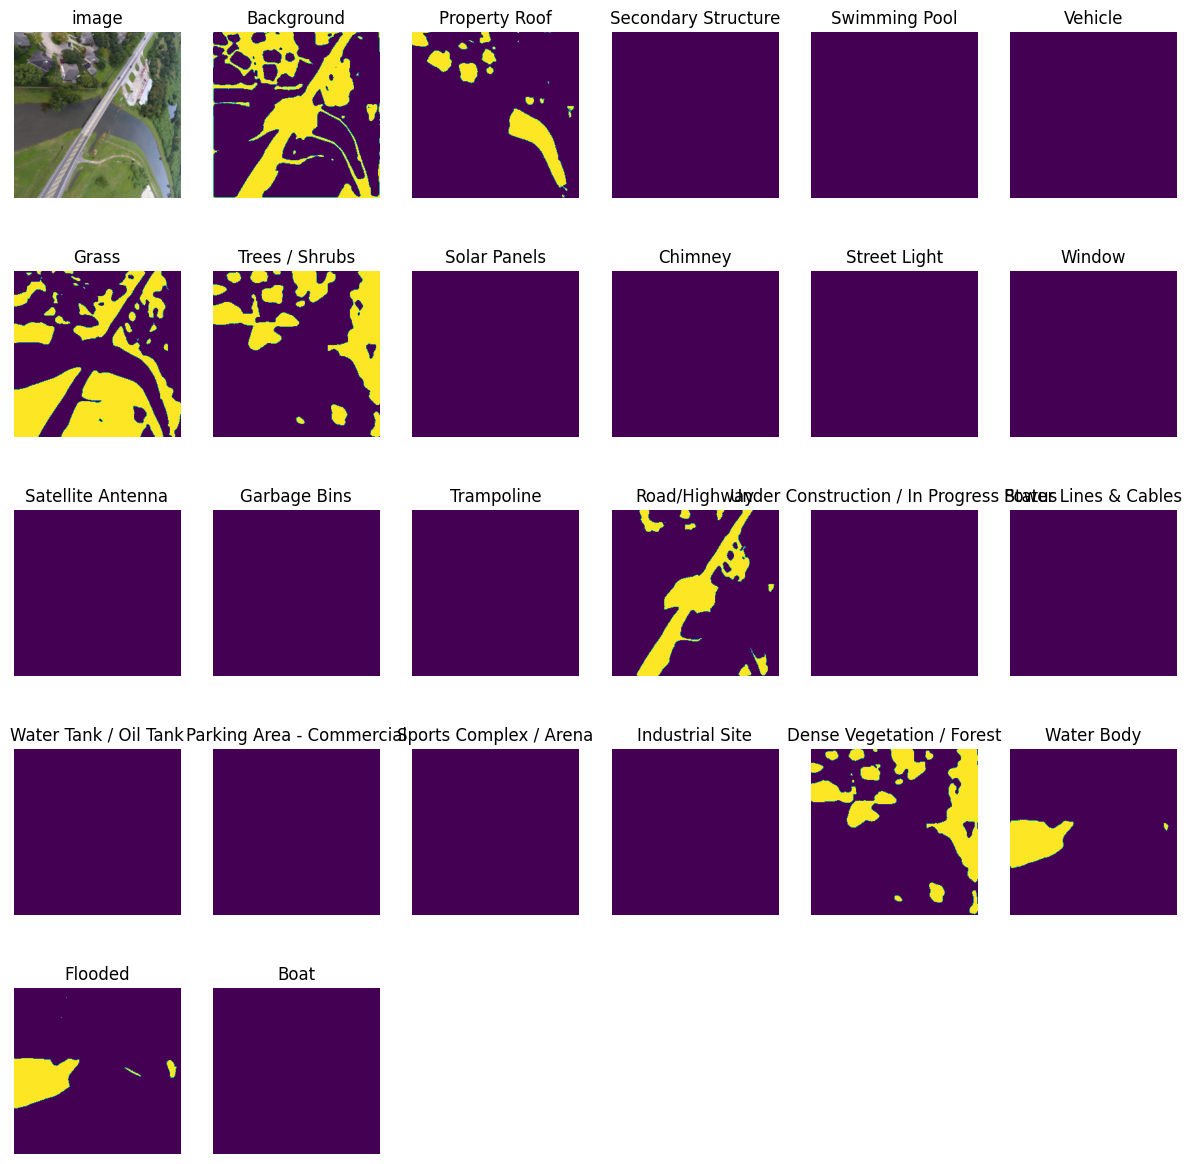

----------------------------------------------------------------------


100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


TRAIN       Epoch: 7 | Epoch metrics | loss: 0.6410, accuracy: 246.639
VALIDATION  Epoch: 7 | Epoch metrics | loss: 0.6485, accuracy: 246.002
----------------------------------------------------------------------
one example:


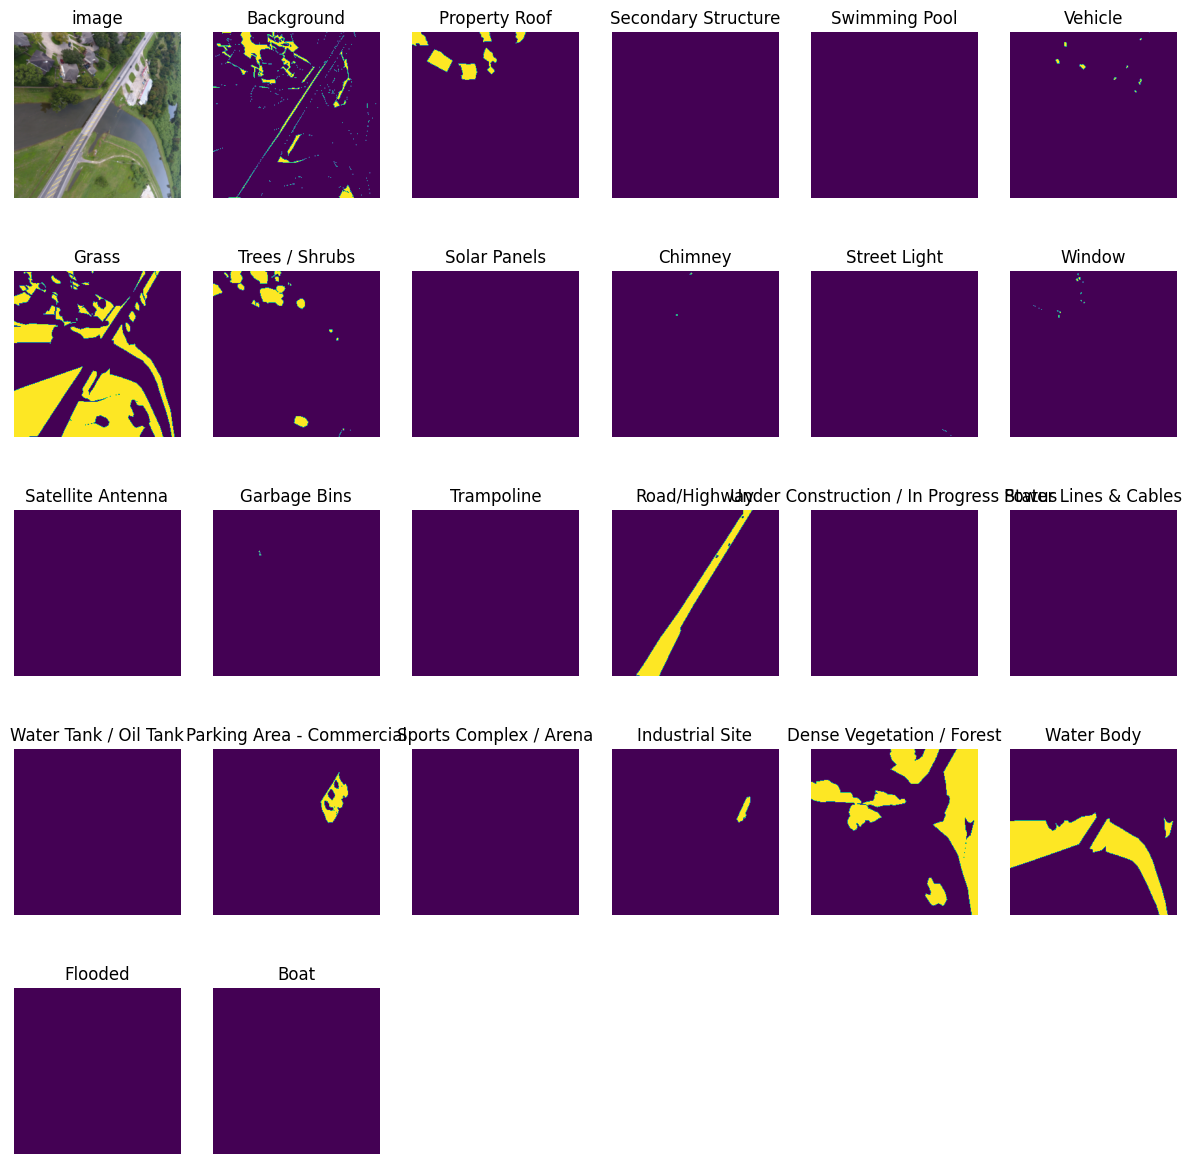

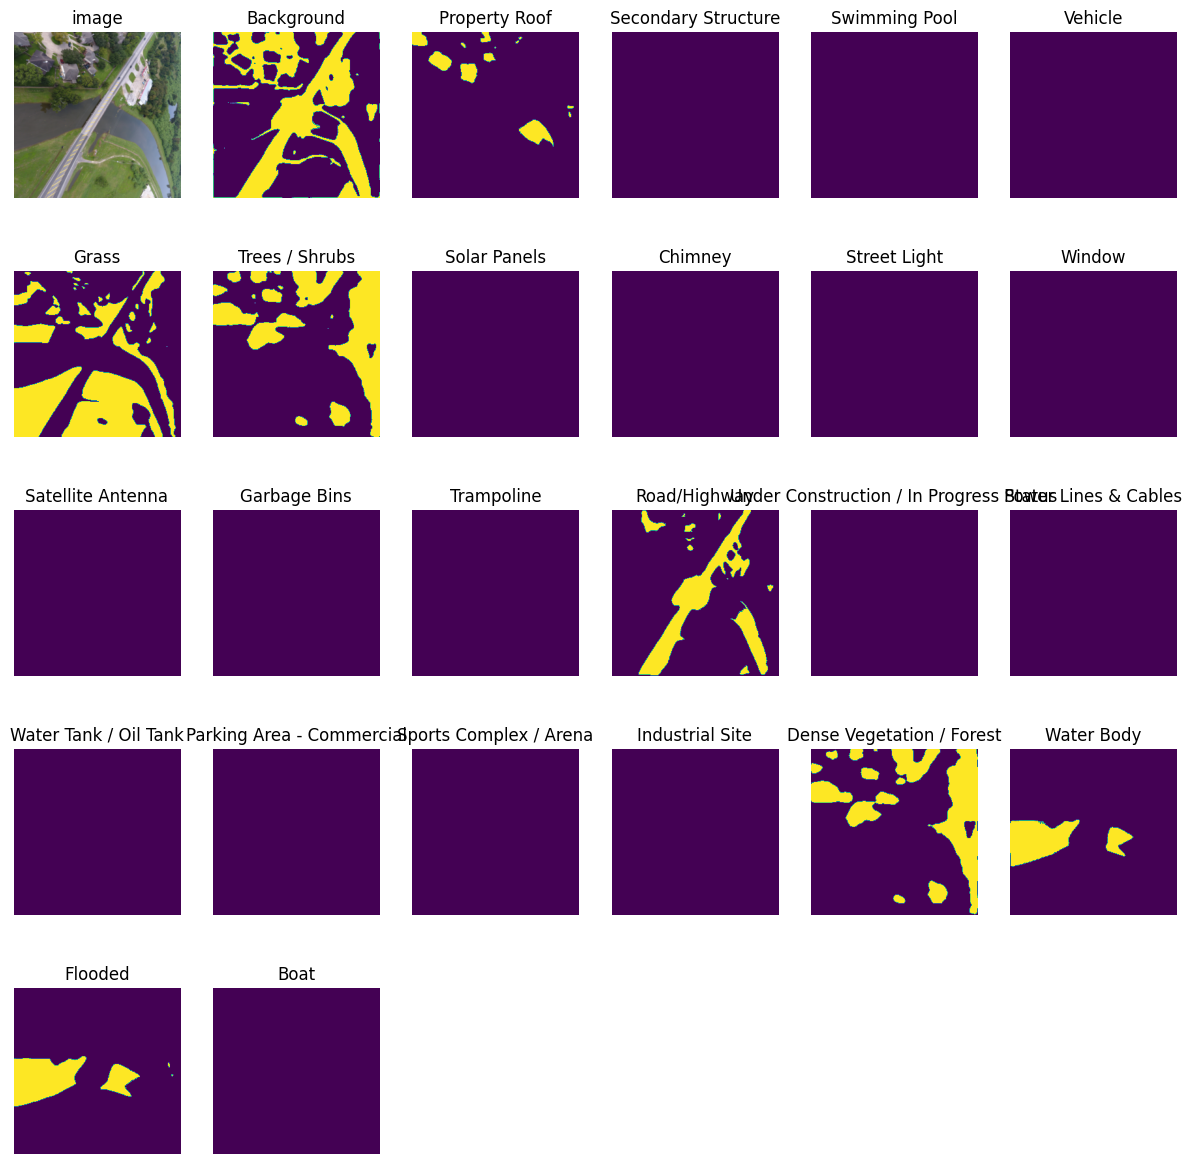

----------------------------------------------------------------------


100%|██████████| 7/7 [00:15<00:00,  2.20s/it]


TRAIN       Epoch: 8 | Epoch metrics | loss: 0.5783, accuracy: 247.467
VALIDATION  Epoch: 8 | Epoch metrics | loss: 0.5822, accuracy: 246.986
----------------------------------------------------------------------
one example:


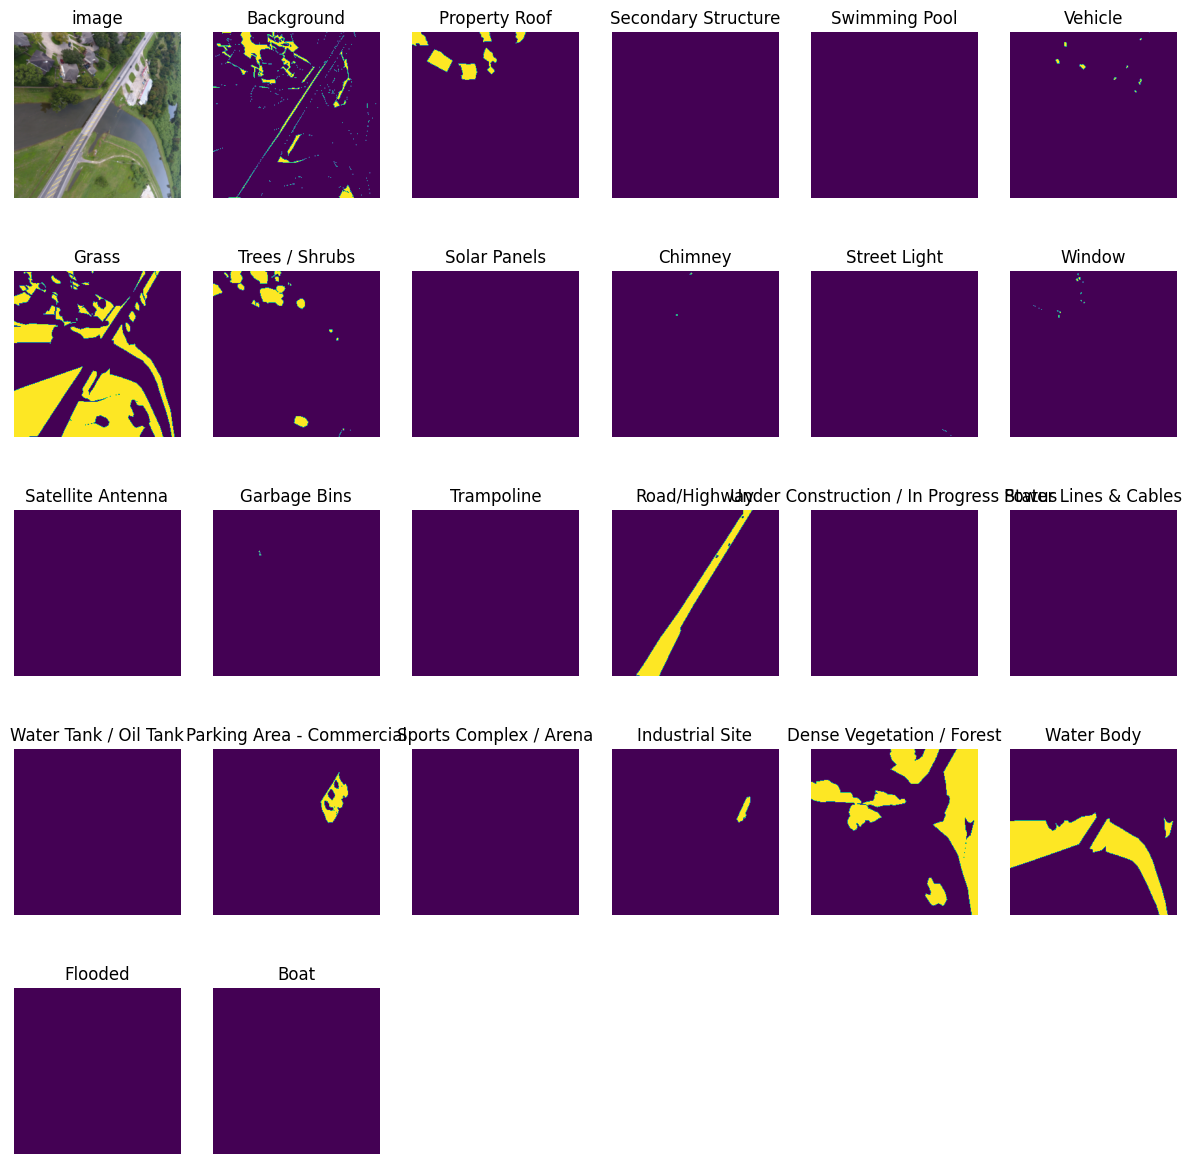

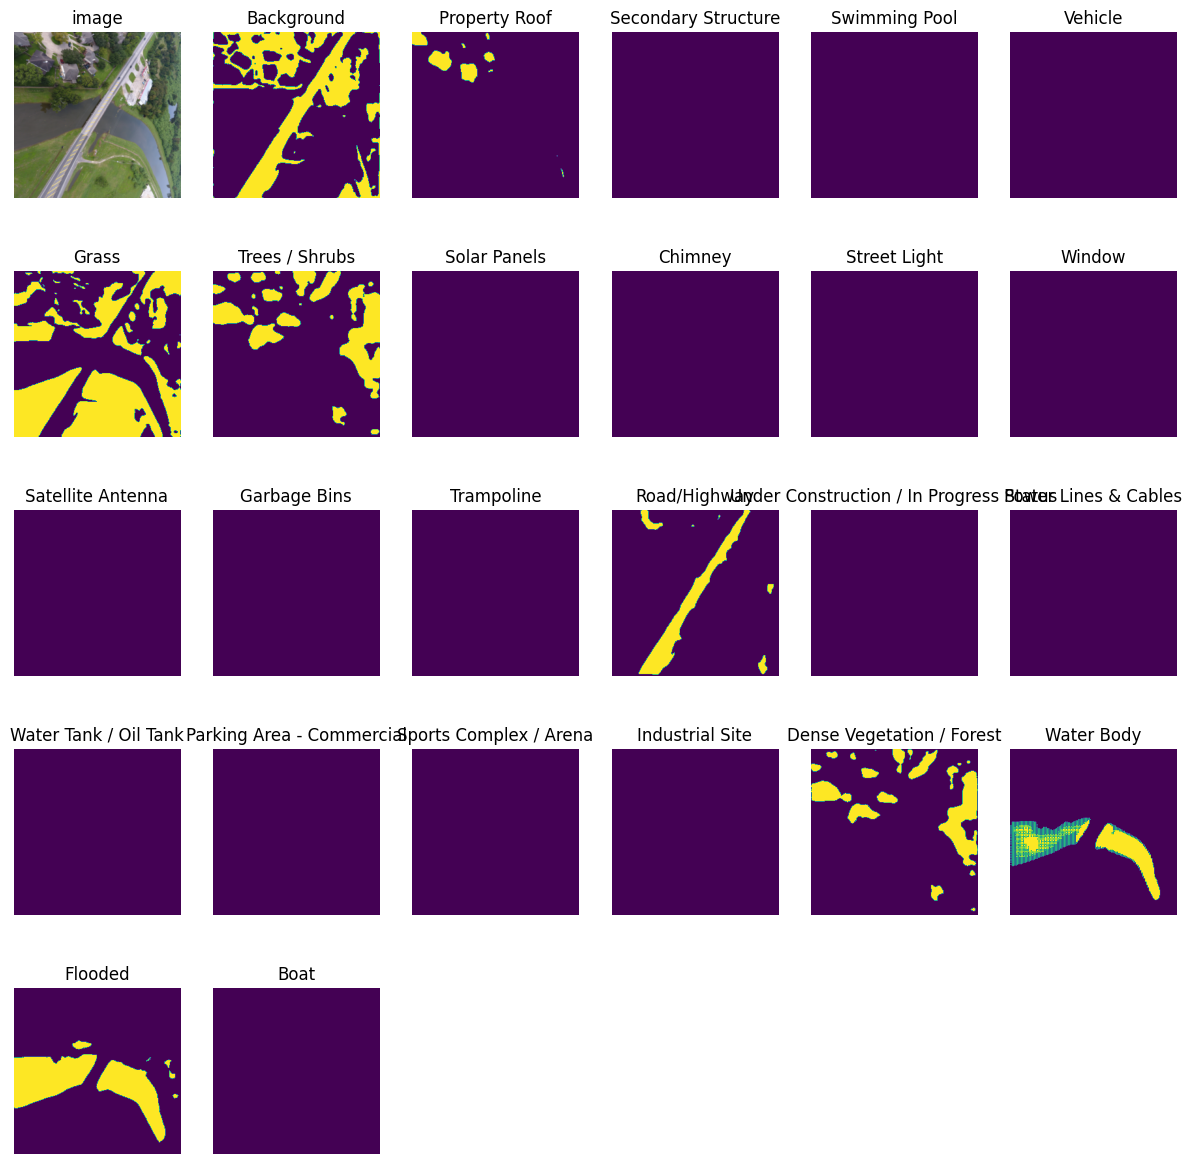

----------------------------------------------------------------------


100%|██████████| 7/7 [00:15<00:00,  2.26s/it]


TRAIN       Epoch: 9 | Epoch metrics | loss: 0.5201, accuracy: 248.455
VALIDATION  Epoch: 9 | Epoch metrics | loss: 0.5302, accuracy: 247.252
----------------------------------------------------------------------
one example:


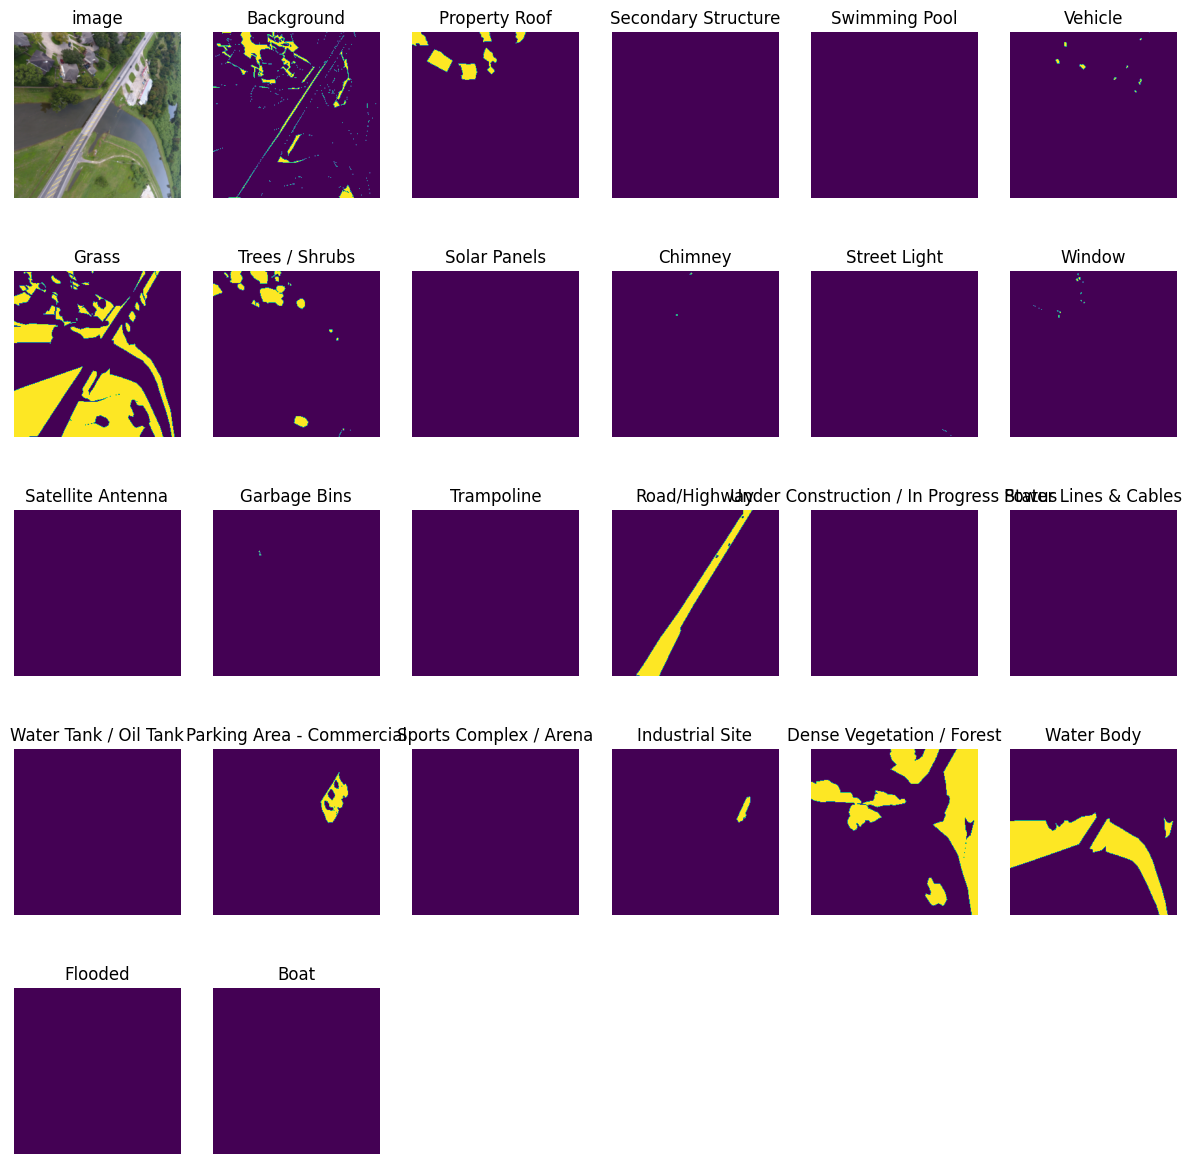

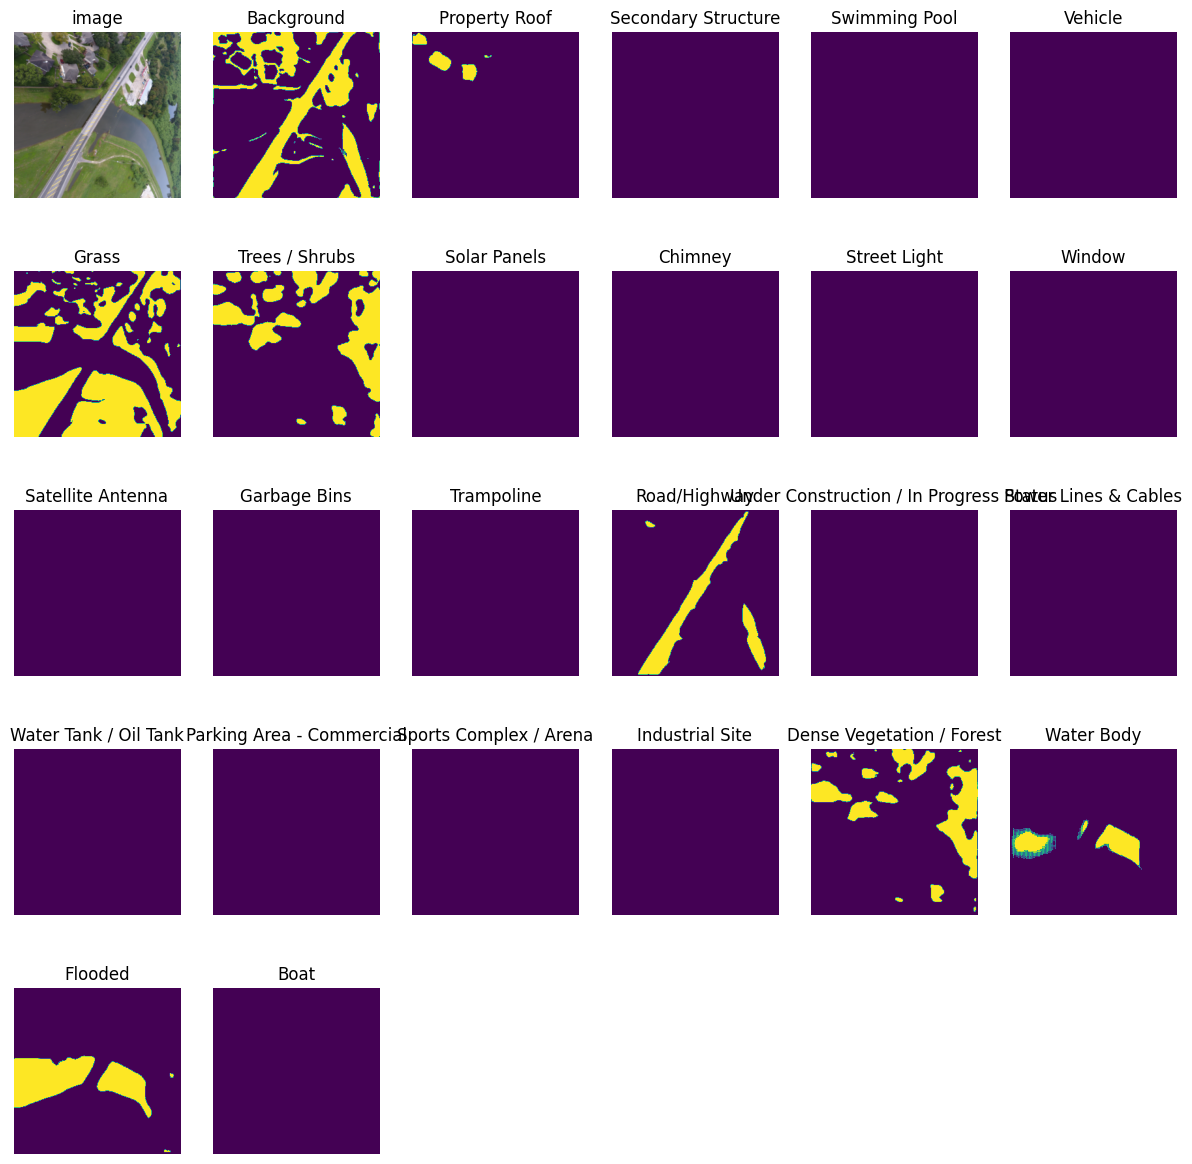

----------------------------------------------------------------------


100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


TRAIN       Epoch: 10 | Epoch metrics | loss: 0.4663, accuracy: 249.511
VALIDATION  Epoch: 10 | Epoch metrics | loss: 0.5104, accuracy: 246.808
----------------------------------------------------------------------
one example:


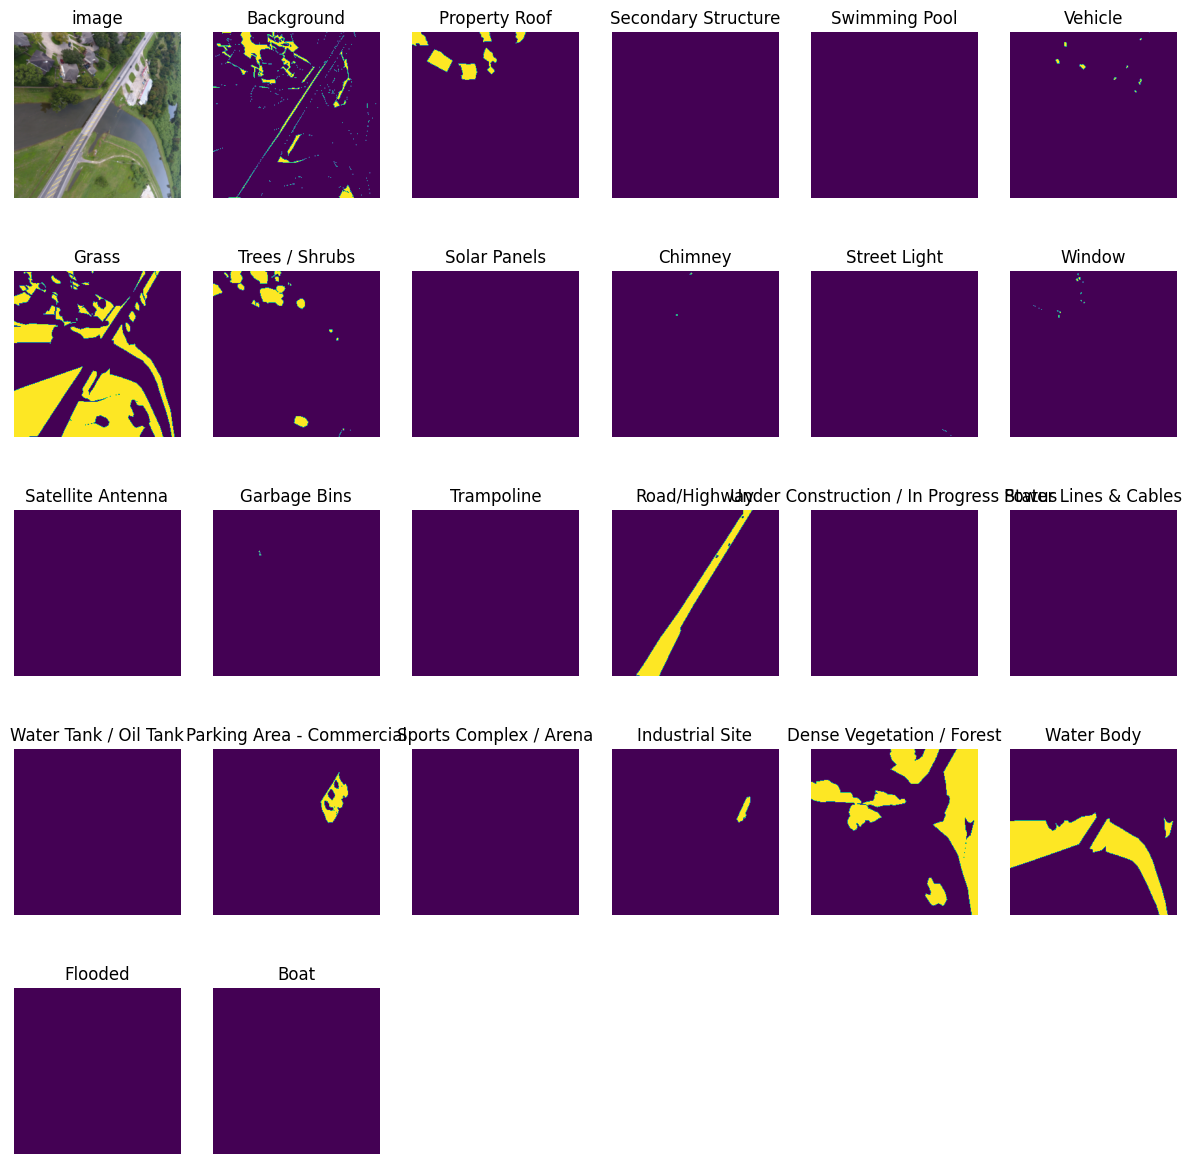

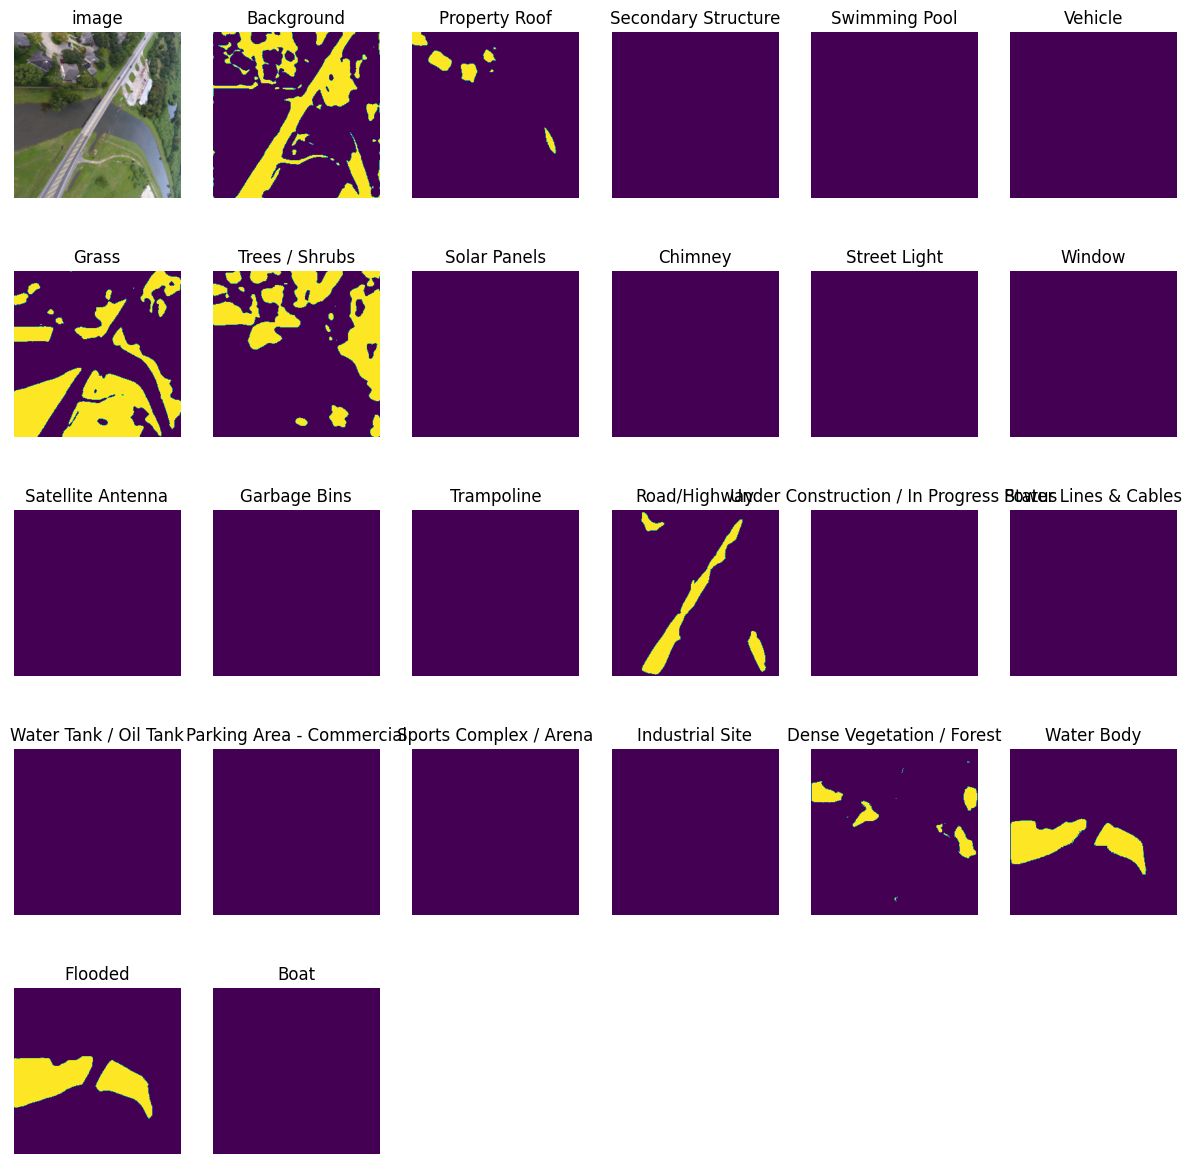

----------------------------------------------------------------------


100%|██████████| 7/7 [00:14<00:00,  2.07s/it]


TRAIN       Epoch: 11 | Epoch metrics | loss: 0.4261, accuracy: 249.867
VALIDATION  Epoch: 11 | Epoch metrics | loss: 0.4681, accuracy: 247.895
----------------------------------------------------------------------
one example:


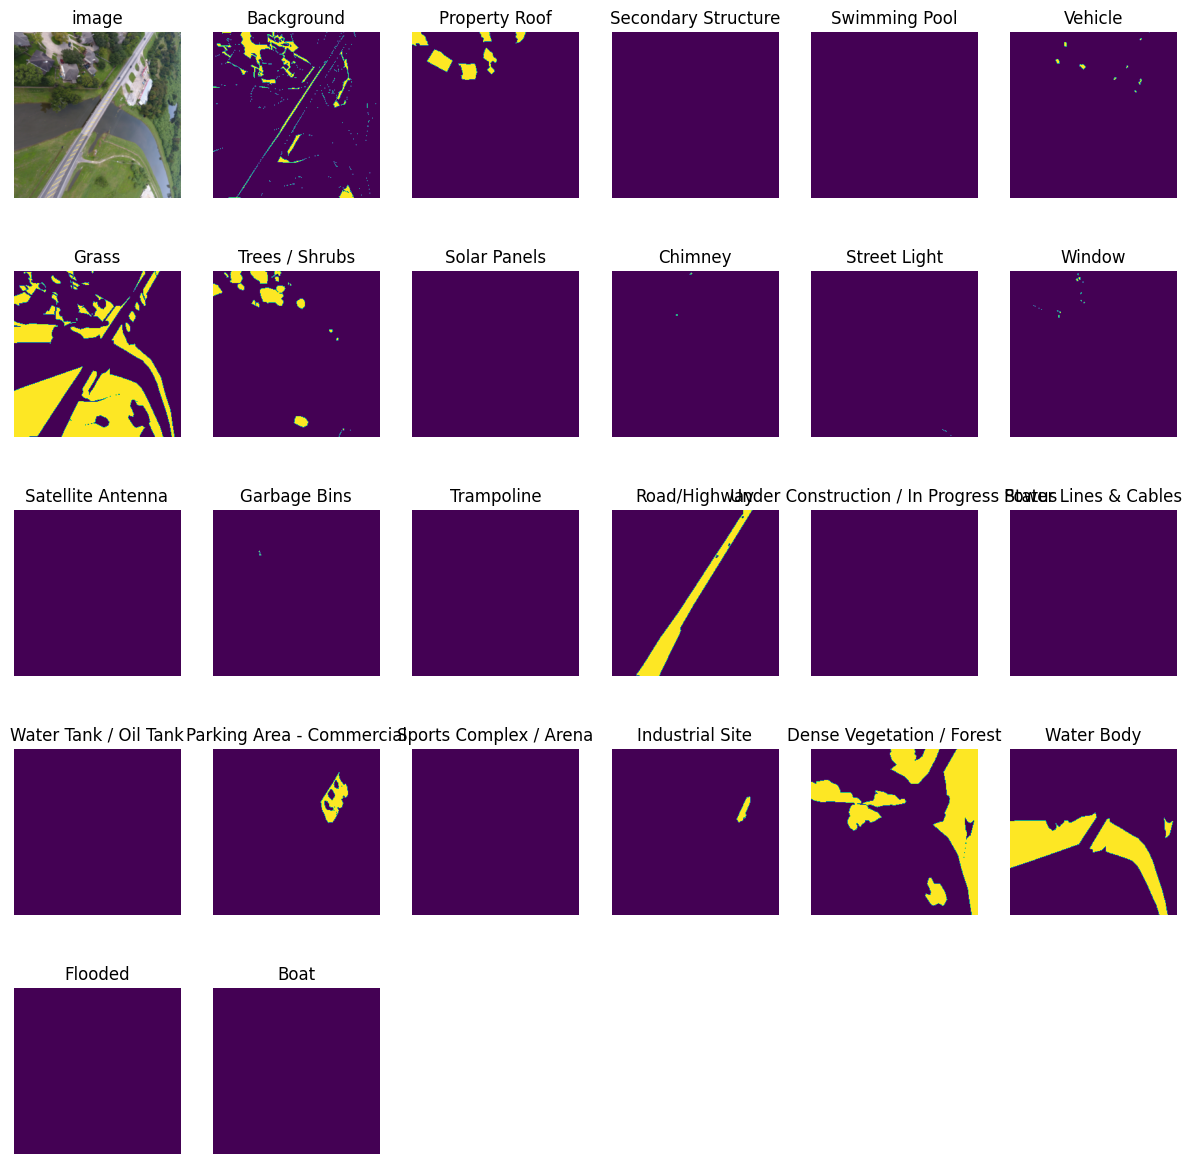

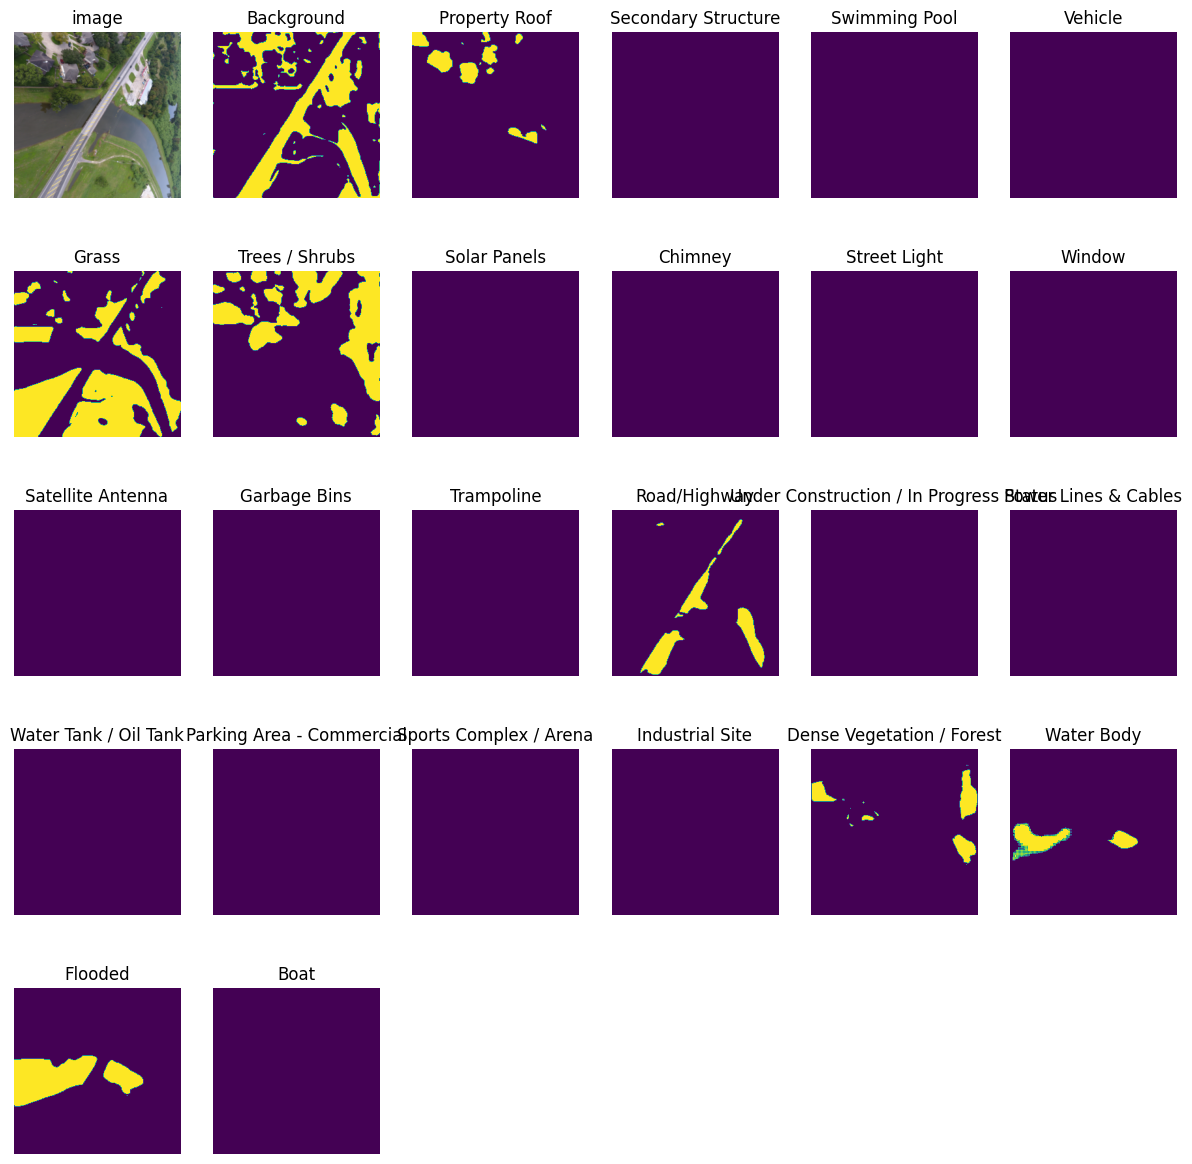

----------------------------------------------------------------------


100%|██████████| 7/7 [00:15<00:00,  2.15s/it]


TRAIN       Epoch: 12 | Epoch metrics | loss: 0.3922, accuracy: 250.088
VALIDATION  Epoch: 12 | Epoch metrics | loss: 0.4503, accuracy: 247.610
----------------------------------------------------------------------
one example:


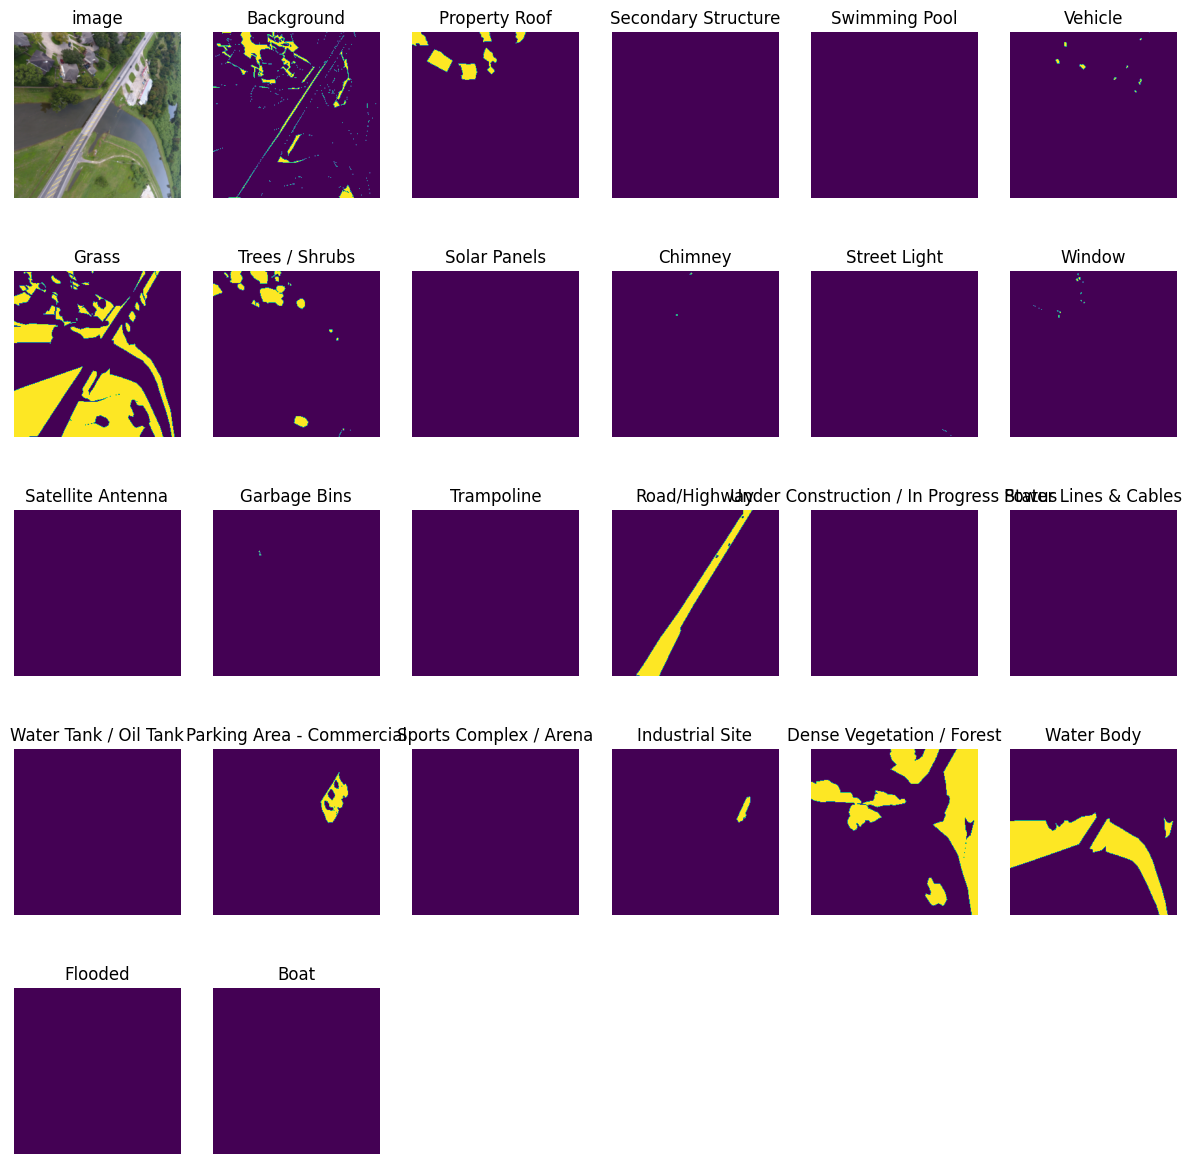

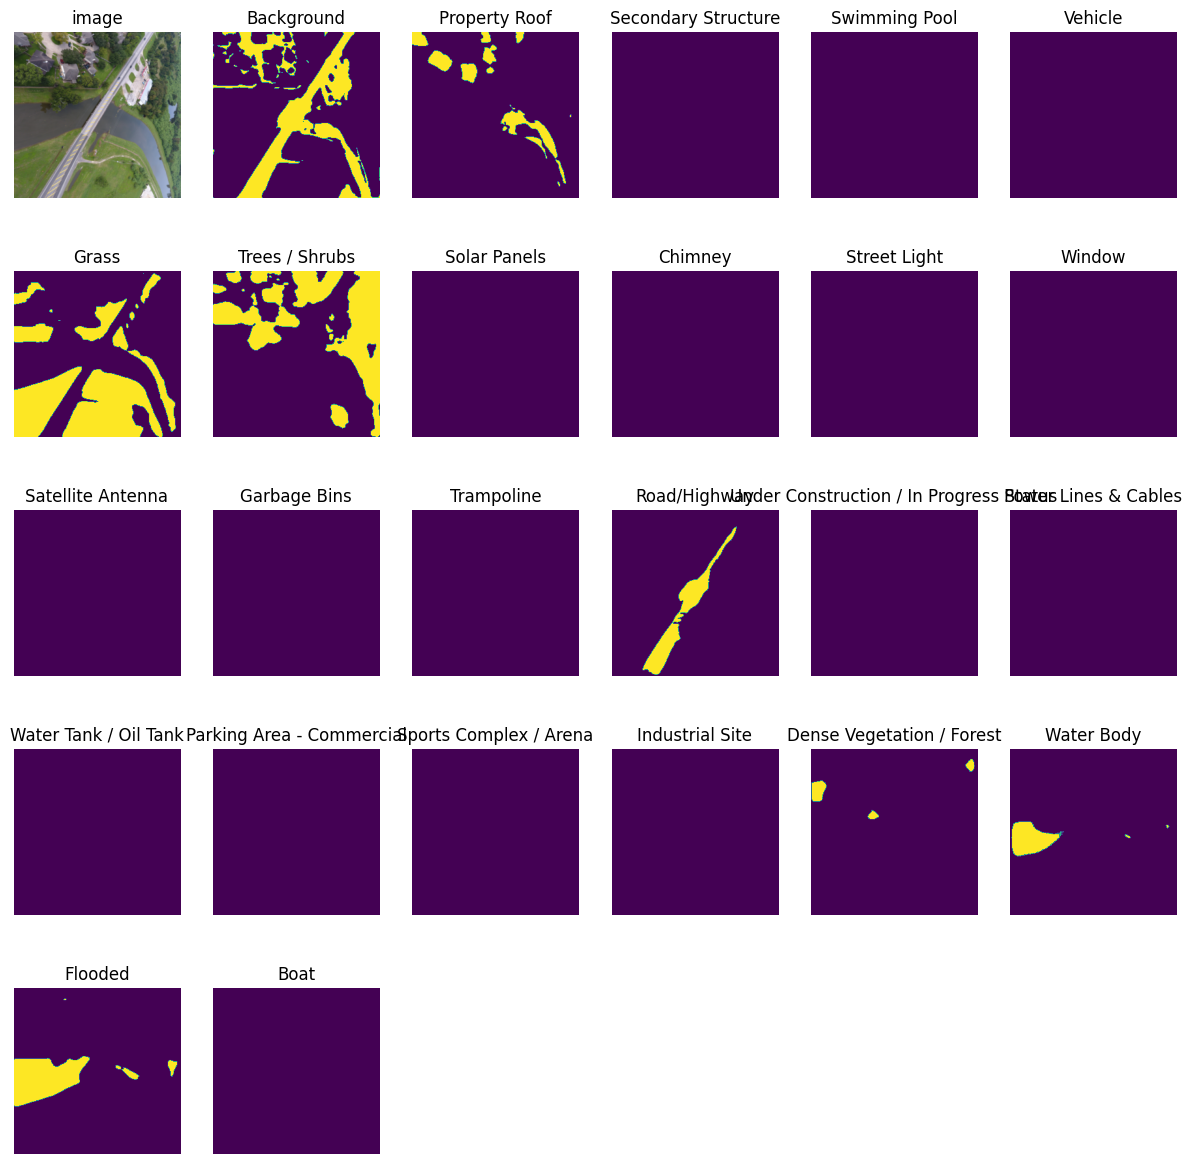

----------------------------------------------------------------------


100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


TRAIN       Epoch: 13 | Epoch metrics | loss: 0.3645, accuracy: 250.370
VALIDATION  Epoch: 13 | Epoch metrics | loss: 0.4325, accuracy: 247.819
----------------------------------------------------------------------
one example:


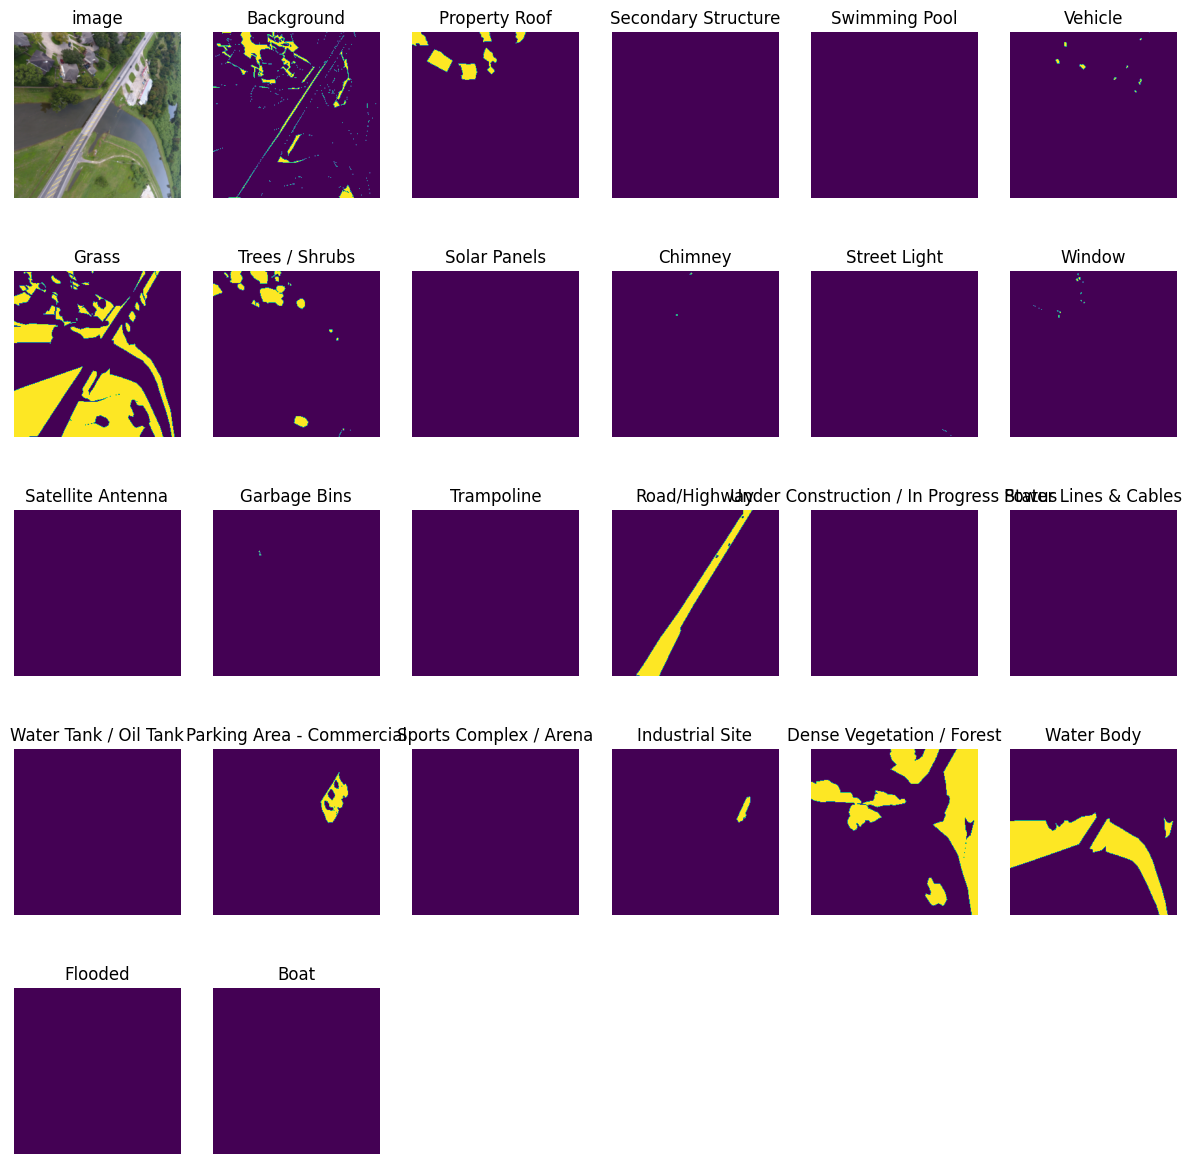

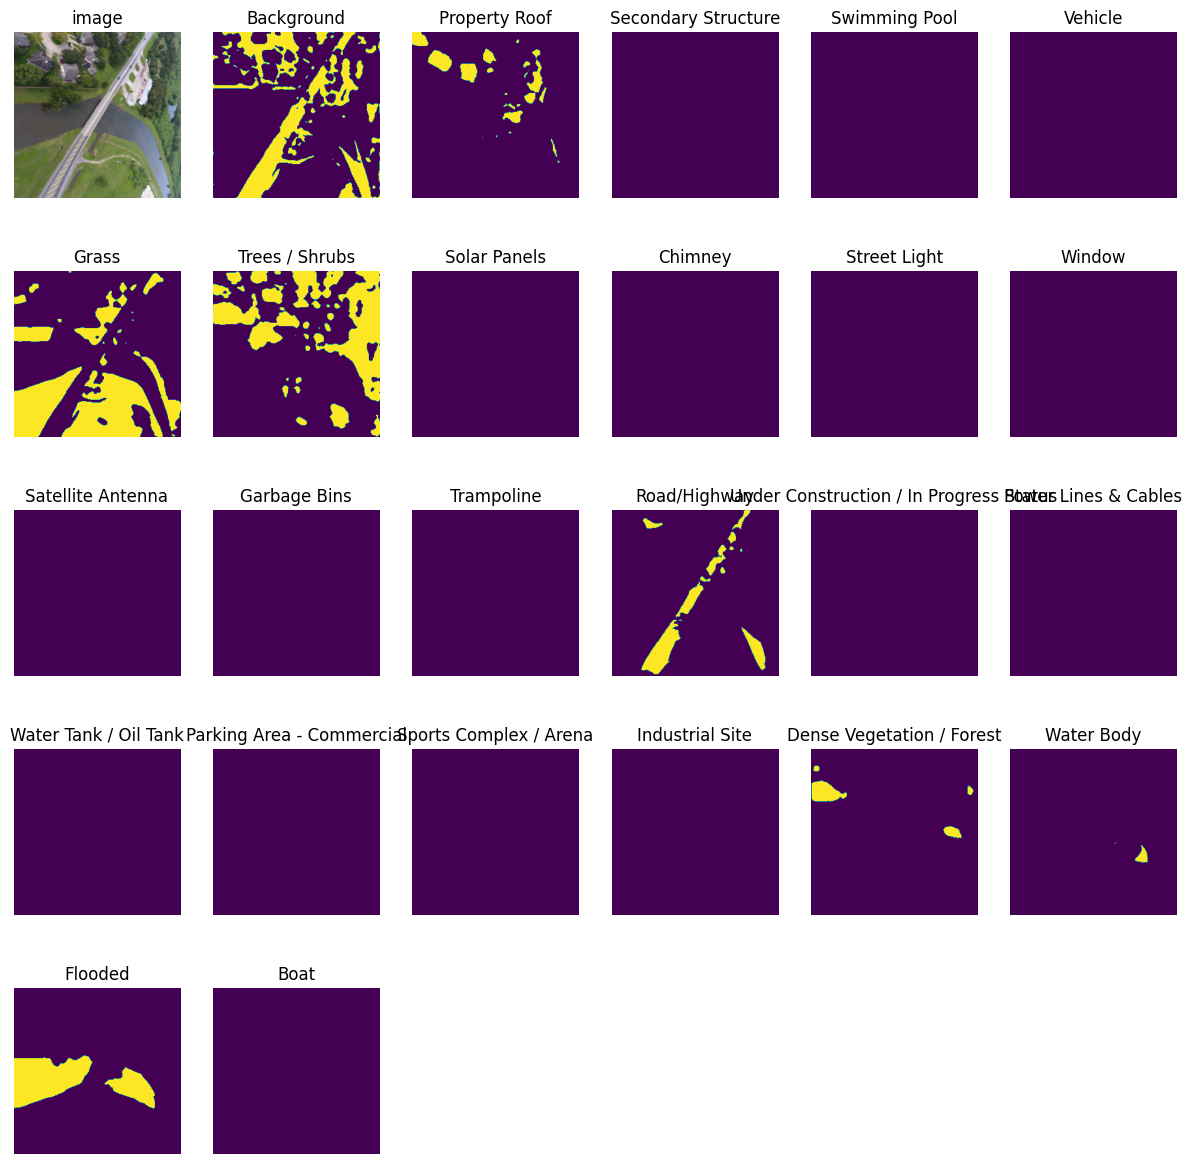

----------------------------------------------------------------------


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


TRAIN       Epoch: 14 | Epoch metrics | loss: 0.3415, accuracy: 250.534
VALIDATION  Epoch: 14 | Epoch metrics | loss: 0.4562, accuracy: 247.324
----------------------------------------------------------------------
one example:


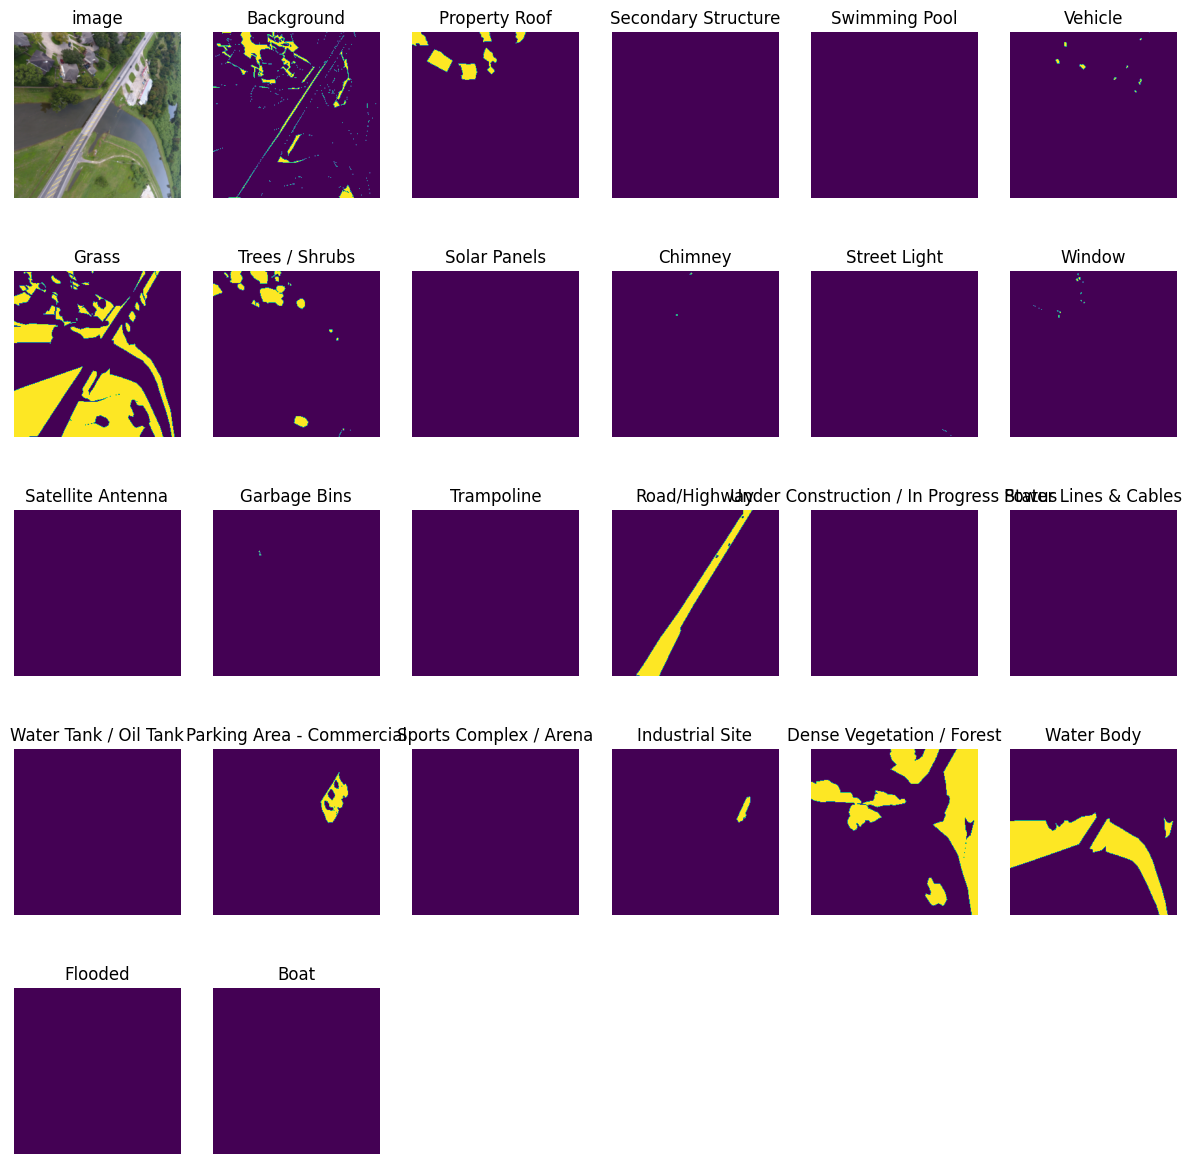

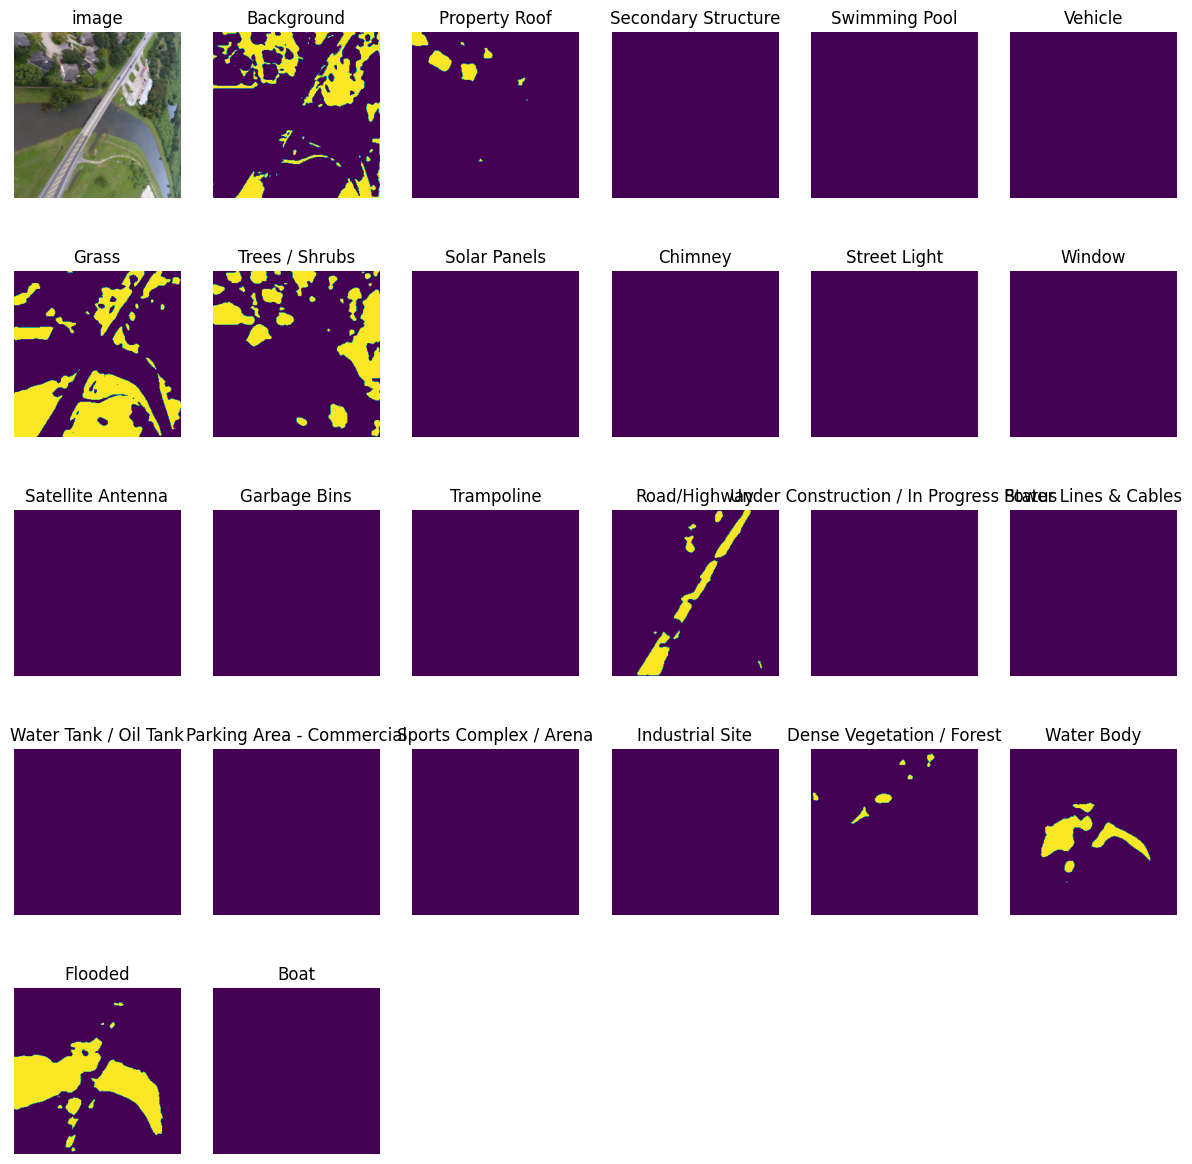

----------------------------------------------------------------------


In [55]:
train(model, epochs, optimizer, criterion)

In [57]:
torch.save(model, "15_epochs_res_net50")